# [ARC] Simple Object Searcher

In [143]:
#!pip install graphviz

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import pandasql as ps

import os, shutil
import json
from pathlib import Path
import sys
from datetime import datetime

import torch.nn.functional as F
from fastai.vision import *
from fastai.utils.mod_display import *
from torchvision import utils

import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from scipy import stats
from sklearn import metrics

from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from fastai.utils.mod_display import *

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from graphviz import Source
from sklearn import tree

from PIL import Image

In [2]:
kaggle_input_path = '/home/kaggle/arc' # '/kaggle/input'

kaggle_arc_path = '/home/kaggle/arc/working_dir' #'/arc/input'


np.set_printoptions(threshold=sys.maxsize)

#for dirname, _, filenames in os.walk(kaggle_input_path):
#    print(dirname)

In [3]:
from pathlib import Path

data_path = Path(kaggle_input_path+'/abstraction-and-reasoning-challenge/')
training_path = data_path / 'training'
evaluation_path = data_path / 'evaluation'
test_path = data_path / 'test'

DEBUG = True

# General helpers

## Functions to load task

In [4]:
def task_sample_arr(taskname, test_train = 'train', in_out = 'input', idx = 0, path=training_path):
    task_file = str(path / (taskname+'.json'))
    with open(task_file, 'r') as f:
        task = json.load(f)
    
    return np.array(task[test_train][idx][in_out])


def load_task(taskname, path=training_path):
    task_file = str(path / (taskname+'.json'))
    with open(task_file, 'r') as f:
        task = json.load(f)
    
    return task


## Function to plot task
Modified version of plot_task from https://www.kaggle.com/inversion/abstraction-and-reasoning-starter-notebook.



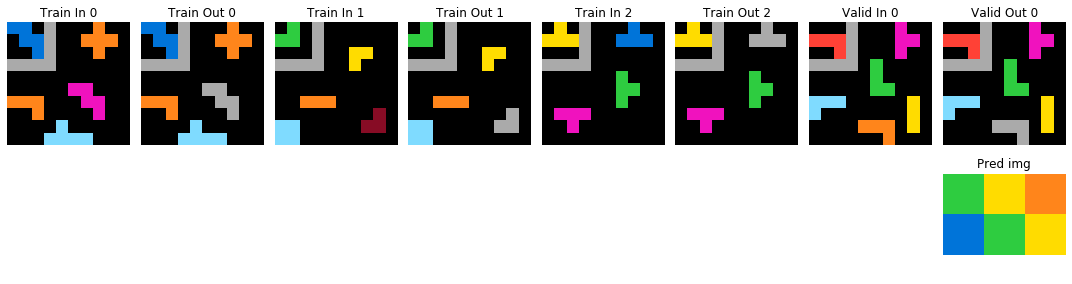

In [9]:
cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25' ,'#FFFFFF'])

cnorm = colors.Normalize(vmin=0, vmax=10) #vmax=9

def plot_task(taskname, path = training_path, pred_imgs=[], max_train = -1):
    """
    Plots the first train and test pairs of a specified task,
    using same color scheme as the ARC app
    """
    
    # loading tasks
    task_file = str(path / (taskname+'.json'))
    with open(task_file, 'r') as f:
        task = json.load(f)
    
    if len(pred_imgs) == 0:
        rows = 2
    else:
        rows = 2
    
    if max_train == -1:
        # show all
        max_train = len(task['train'])  
    
    fig, axs = plt.subplots(rows, (max_train+len(task['test']))*2, figsize=(15,rows*2))
    offset = 0
    for i in range(max_train):
        axs[0, i*2].imshow(task['train'][i]['input'], cmap=cmap, norm=cnorm)
        axs[0, i*2].axis('off')
        axs[0, i*2].set_title('Train In '+str(i))
        
        axs[0, i*2+1].imshow(task['train'][i]['output'], cmap=cmap, norm=cnorm)
        axs[0, i*2+1].axis('off')
        axs[0, i*2+1].set_title('Train Out '+str(i))
        
        offset+=2
        
    for i in range(len(task['test'])):
        j=i*2+offset
        axs[0, j].imshow(task['test'][i]['input'], cmap=cmap, norm=cnorm)
        axs[0, j].set_title('Valid In '+str(i))
        axs[0, j].axis('off')
        
        axs[0, j+1].imshow(task['test'][i]['output'], cmap=cmap, norm=cnorm)
        axs[0, j+1].set_title('Valid Out '+str(i))
        axs[0, j+1].axis('off')
            
    if rows == 2:
        for p, pred_img in enumerate(pred_imgs):
            y = -2*(len(pred_imgs))+2*p+1
            axs[1, y].imshow(pred_img, cmap=cmap, norm=cnorm)
            axs[1, y].set_title('Pred img')

            rs_pred_img = pred_img.astype('int8')
        
        for i in range((len(task['test'])+max_train)*2):
            axs[1, i].axis('off')
                
    plt.tight_layout()
    plt.show()
    

# Test
if DEBUG:
    taskname = '63613498' #'ae58858e'
    plot_task(taskname, path = training_path, pred_imgs=[np.array([[3,4,7],[1,3,4]])]) #training_path #evaluation_path)#, max_train=2)

    plt.show() 


# Object detection

## Kernels

In [11]:
def k_gen(kernel, ignore_dir = True):
    """
    Generic kernel function. Adds distortion if ignore_dir = False, which causes the direction of the object being relevant:
    
        ignore_dir == True:
            
            xxxx               xxx
             xxx   is equals   xxxx
        
        ignore_dir == False:
        
            xxxx                   xxx
             xxx   is not equals   xxxx
    
    Adding distortion might make the "Hash" be a bit more robust regarding uniqueness for some symetric objects (see issue with k_uni).
    """
    
    if ignore_dir:
        distortion = np.array([[1, 1, 1],[1, 1, 1],[1, 1, 1]]);
    else:
        distortion = np.array([[1.01, 1.02, 1.03],[1.04, 1.05, 1.06],[1.07, 1.08, 1.09]]);
    
    return kernel*distortion
    

def k_uni(ignore_dir = True):
    """
    Direction does not matter, e.g. 
    
        xxxx               xxx
         xxx   is equals   xxxx
         
    "Hash" might not be unique for some symetric objects, e.g.

          x                      x
         x    considered equals   x
        xx                       xx
    
    """
    kernel = np.array([[1, 1, 1],
                           [1, 1, 1],
                           [1, 1, 1]])
    
    return k_gen(kernel, ignore_dir)


def k_plus(ignore_dir = True):
    """
    Same as k_uni, but doesn't consider diagonals as connection, e.g.
    
          xx
          xx     k_uni: 1 object
        xx       k_plus: 2 objects
        xx     
        
    """
    kernel = np.array([[0, 1, 0],
                           [1, 1, 1],
                           [0, 1, 0]])
    
    return k_gen(kernel, ignore_dir)


def k_x(ignore_dir = True):
    """
    Same as k_uni, but only considers diagonals as connection, e.g.
    
          xx
          xx     k_uni: 1 object
        xx       k_plus: 2 objects
        xx       k_x: 3 objects
        
    """
    kernel = np.array([[1, 0, 1],
                           [0, 1, 0],
                           [1, 0, 1]])
    
    return k_gen(kernel, ignore_dir)


In [12]:
k_plus()

array([[0, 1, 0],
       [1, 1, 1],
       [0, 1, 0]])

In [13]:
class ObjectDetail:
    
    
    def __init__(self, colors, locs, shadow_locs, freq_per_color, freq_total, parent_objects, obj_classes):
        self.colors = colors
        self.locs = locs
        self.shadow_locs = shadow_locs
        self.freq_per_color = freq_per_color
        self.freq_total = freq_total
        self.parent_objects = parent_objects
        self.obj_classes = obj_classes


        
class ClassDetail:
    
    
    def __init__(self, colors, locs, shadow_locs, freq_per_color, freq_total, parent_objects, obj_classes):
        self.colors = colors
        self.locs = locs
        self.shadow_locs = shadow_locs
        self.freq_per_color = freq_per_color
        self.freq_total = freq_total
        self.parent_objects = parent_objects
        self.obj_classes = obj_classes

In [14]:
class ObjectIndex:
    SHADOW_CHANNEL = 10
    
    
    def __init__(self, img, kernel=k_uni(), neighbours = 10, bg = 0, debug = False):
    
        self.debug = debug
    
        self.img = img
        
        self.bg = bg
        
        self.kernel = kernel
        
        self.data = self.__cluster_parent_objects(self.img, self.kernel, bg)
          
    
    def siblings(self, xy_filter = None, child_key = 'parent_id', agg_key = 'class_id', agg_features=None):     

        # focus on siblings of xy_filter
        if isinstance(xy_filter, pd.DataFrame):
            m = self.data.merge(xy_filter[['x','y']].drop_duplicates(), on = ['x', 'y'], how = 'inner') #xy_filter,'color_out'
        else: 
            m = self.data

        ## Dependencies search: agg by classid

        temp = m[[agg_key]].merge(self.data[agg_features + [child_key]], on=agg_key, how='inner') #m[[agg_key, 'color_out']]
        temp = temp[~temp[child_key].isin(m[child_key].tolist())]
        temp = temp.drop_duplicates() 
        
        return temp
    

    def non_siblings(self, xy_filter = None, child_key = 'parent_id', agg_key = 'class_id', agg_features = None):
        # focus on siblings of xy_filter
        if isinstance(xy_filter, pd.DataFrame):
            m = self.data.merge(xy_filter[['x','y','color_out']].drop_duplicates(), on = ['x', 'y'], how = 'inner')
        else: 
            m = self.data

        temp = self.data[~self.data[agg_key].isin(m[agg_key].tolist())]
        temp = temp[[child_key]+agg_features].drop_duplicates() 
        return temp

    
    def __cluster_parent_objects(self,img, k, bg):
        
        DEBUG = self.debug
        
        COLOR_OFFSET = 99
        
        if DEBUG:
            print('BG:', bg)
            print('Kernel\n', k)
            print('IMAGE\n', img)
        
        bg += COLOR_OFFSET
        
        # pad img
        img = np.pad(img+COLOR_OFFSET, ((1, 1), (1, 1)), 'constant', constant_values=(0, 0)) 
        
        k_area = np.argwhere(k>0)+np.array([-1,-1])
        obj_hier = pd.DataFrame(columns=['x', 
                                         'y',
                                         'color', 
                                         'parent_id', 
                                         'grandparent_id'])
        
        tracker = np.zeros(img.shape)
        gp_tracker = np.zeros(img.shape)
        
        max_parent = 0
        max_grandparent = 0
        for i in np.argwhere(img > 0):
            cur_color = img[i[0], i[1]]
            
            # if loc has been mapped before get parent_id
            cur_parent = tracker[i[0], i[1]]
            cur_grandparent = gp_tracker[i[0], i[1]]
            # if loc is evaluated the first time generate new parent_id 
            if cur_parent == 0:
                max_parent += 1
                cur_parent = max_parent
                tracker[i[0], i[1]] = cur_parent
                
            if cur_grandparent == 0:
                max_grandparent += 1
                cur_grandparent = max_grandparent
                if cur_color != bg:
                    gp_tracker[i[0], i[1]] = cur_grandparent
            
            for ka in k_area:
                lu_loc = i + ka
                ka_color = img[lu_loc[0], lu_loc[1]]
                if cur_color == ka_color:
                    # set parent if colors are equals
                    ka_parent = tracker[lu_loc[0], lu_loc[1]]
                    if ka_parent == 0: 
                        tracker[lu_loc[0], lu_loc[1]] = cur_parent
                    else:
                        # rename ka parent with curent parent id
                        np.place(tracker, tracker == ka_parent, [cur_parent])
                if ka_color not in [bg, 0] and cur_color != bg:
                    # only change grandparent ==> connects two parents
                    ka_gparent = gp_tracker[lu_loc[0], lu_loc[1]]
                    if ka_gparent == 0: 
                        gp_tracker[lu_loc[0], lu_loc[1]] = cur_grandparent
                    else:
                        # rename ka grandparent with curent grandparent id
                        np.place(gp_tracker, gp_tracker == ka_gparent, [cur_grandparent])
        
        # unpad:
        tracker = tracker[1:-1,1:-1]
        gp_tracker = gp_tracker[1:-1,1:-1]
        img = img[1:-1,1:-1] - COLOR_OFFSET
        
        if DEBUG:
            print('PARENT IDs\n', tracker)    
            print('GRANDPARENT IDs\n', gp_tracker)    
       
        # Fill DataFrame
        for i in np.argwhere(img > -10000):#img > 0): #
            
            obj_hier = obj_hier.append({'x': int(i[1]), 
                                        'y': int(i[0]),
                                        'color': img[int(i[0]), int(i[1])], 
                                        'parent_id': int(tracker[i[0], i[1]]), 
                                        'grandparent_id': int(gp_tracker[i[0], i[1]])
                                        }, 
                                       ignore_index=True)
                                    
        obj_hier['is_bg'] = obj_hier['color'] == bg
        obj_hier['p_bbox_x1'] = obj_hier.groupby(['parent_id'])['x'].transform('min')
        obj_hier['p_bbox_y1'] = obj_hier.groupby(['parent_id'])['y'].transform('min')
        obj_hier['p_bbox_x2'] = obj_hier.groupby(['parent_id'])['x'].transform('max')
        obj_hier['p_bbox_y2'] = obj_hier.groupby(['parent_id'])['y'].transform('max')
        obj_hier['p_bbox_width'] = obj_hier['p_bbox_x2'] - obj_hier['p_bbox_x1'] + 1
        obj_hier['p_bbox_height'] = obj_hier['p_bbox_y2'] - obj_hier['p_bbox_y1'] + 1
        obj_hier['x_norm_0'] = obj_hier['x'] - obj_hier['p_bbox_x1']
        obj_hier['y_norm_0'] = obj_hier['y'] - obj_hier['p_bbox_y1']
        obj_hier['x_norm_flip_v'] = obj_hier['p_bbox_x2'] - obj_hier['x'] #reflected/mirrored
        obj_hier['y_norm_flip_v'] = obj_hier['y_norm_0']
        obj_hier['x_norm_flip_h'] = obj_hier['x_norm_0']
        obj_hier['y_norm_flip_h'] = obj_hier['p_bbox_y2'] - obj_hier['y'] 
        obj_hier['x_norm_90'] = obj_hier['y_norm_0']
        obj_hier['y_norm_90'] = obj_hier['p_bbox_width'] - obj_hier['x_norm_0'] - 1
        obj_hier['x_norm_180'] = obj_hier['p_bbox_width'] - obj_hier['x_norm_0'] - 1
        obj_hier['y_norm_180'] = obj_hier['p_bbox_height'] - obj_hier['y_norm_0'] - 1
        obj_hier['x_norm_270'] = obj_hier['p_bbox_height'] - obj_hier['y_norm_0'] - 1
        obj_hier['y_norm_270'] = obj_hier['x_norm_0'] 
        
        ## generate class id and class rotation
        rotation_suffix = ['_0', '_90', '_180', '_270', '_flip_v', '_flip_h']
        for rs in rotation_suffix:
            obj_hier['xy_norm_key'] = obj_hier['x_norm'+rs].astype(str) + ' ' + obj_hier['y_norm'+rs].astype(str)
            obj_hier['class_id'+rs] = obj_hier.sort_values(['xy_norm_key']).groupby(['parent_id'])['xy_norm_key'].transform(lambda x: ''.join(x.to_string(index=False))).str.replace('(\\n)', '')
            obj_hier['class_id_gp'+rs] = obj_hier.sort_values(['xy_norm_key']).groupby(['grandparent_id'])['xy_norm_key'].transform(lambda x: ''.join(x.to_string(index=False))).str.replace('(\\n)', '')
        
        ## class id
        obj_hier['class_id'] = obj_hier[['class_id' + rs for rs in rotation_suffix]].min(axis=1)
        obj_hier['class_id_gp'] = obj_hier[['class_id_gp' + rs for rs in rotation_suffix]].min(axis=1)
        
        ## class rotation
        obj_hier['temp'] = obj_hier.groupby(['class_id'])['class_id_0'].transform('nunique')
        obj_hier['class_rotation'] = 0
        obj_hier['temp_gp'] = obj_hier.groupby(['class_id'])['class_id_0'].transform('nunique')
        obj_hier['class_rotation_gp'] = 0
        for rs in list(reversed(rotation_suffix)):
            obj_hier.loc[(obj_hier['class_id' + rs]==obj_hier['class_id']) & (obj_hier['temp'] != 1), 'class_rotation'] = rs[1:]
            obj_hier.loc[(obj_hier['class_id_gp' + rs]==obj_hier['class_id_gp']) & (obj_hier['temp_gp'] != 1), 'class_rotation_gp'] = rs[1:]
                     
        obj_hier['class_id_norm'] = obj_hier['class_id']
        obj_hier['class_id'] = obj_hier['class_id_0']
        obj_hier['class_id_gp_norm'] = obj_hier['class_id_gp']
        obj_hier['class_id_gp'] = obj_hier['class_id_gp_0']
        
        # clean up
        obj_hier.drop(['xy_norm_key', 'temp', 'temp_gp']+
                      ['class_id' + rs for rs in rotation_suffix]+
                      ['class_id_gp' + rs for rs in rotation_suffix], inplace = True, axis = 1)
         
        # stats
        obj_hier['obj_per_parent'] = obj_hier.groupby(['parent_id'])['parent_id'].transform('count')
        obj_hier['obj_per_gparent'] = obj_hier.groupby(['grandparent_id'])['grandparent_id'].transform('count')
        obj_hier['obj_per_class'] = obj_hier.groupby(['class_id_norm'])['class_id_norm'].transform('count')
        obj_hier['classes_per_gpclass'] = obj_hier.groupby(['class_id_gp_norm'])['class_id_norm'].transform('nunique')
        obj_hier['rotations_per_class'] = obj_hier.groupby(['class_id_norm'])['parent_id'].transform('nunique')
        obj_hier['o_p_cnt_rank'] = obj_hier['obj_per_parent'].rank(method = 'dense')
        obj_hier['o_c_cnt_rank'] = obj_hier['obj_per_class'].rank(method = 'dense')
        obj_hier['p_c_cnt_rank'] = obj_hier['rotations_per_class'].rank(method = 'dense')
        
        # additional features
        
        sqlstmt = '''
        select a.*, 
          ifnull((select b.class_id 
             from obj_hier b
              where (b.p_bbox_x2 > a.p_bbox_x2
                     or b.p_bbox_x2 = '''+str(img.shape[1])+''')
                and (b.p_bbox_x1 < a.p_bbox_x1
                     or b.p_bbox_x1 = 0)
                and (b.p_bbox_y2 > a.p_bbox_y2
                     or b.p_bbox_y2 = '''+str(img.shape[0])+''')
                and (b.p_bbox_y1 < a.p_bbox_y1
                     or b.p_bbox_y1 = 0) 
                and '''+str(bg-COLOR_OFFSET)+''' not in (b.color, a.color)
                order by b.p_bbox_width * b.p_bbox_height
                limit 1), 0) as boxed_by_class_id, 
          ifnull((select b.class_id 
             from obj_hier b
              where (b.p_bbox_x2 > a.p_bbox_x2
                     or b.p_bbox_x2 = '''+str(img.shape[1])+''')
                and (b.p_bbox_x1 < a.p_bbox_x1
                     or b.p_bbox_x1 = 0)
                and (b.p_bbox_y2 > a.p_bbox_y2
                     or b.p_bbox_y2 = '''+str(img.shape[0])+''')
                and (b.p_bbox_y1 < a.p_bbox_y1
                     or b.p_bbox_y1 = 0) 
                order by b.p_bbox_width * b.p_bbox_height
                limit 1), 0) as boxed_by_class_id_incl_bg
        from obj_hier a
        '''
        
        obj_hier = ps.sqldf(sqlstmt,locals())

        
        for c in obj_hier.columns:
            try:
                obj_hier[c] = obj_hier[c].astype(int)
            except:
                None
        
        return obj_hier  
    
    
    
### Test

if DEBUG:
    img = task_sample_arr('63613498', test_train = 'train', in_out = 'output', idx = 1, path = training_path) #e8593010
    oi = ObjectIndex(img, kernel = k_plus(), bg = 0, debug = True) #e8593010  #6e82a1ae #63613498 #e8593010
    display(oi.data)

BG: 0
Kernel
 [[0 1 0]
 [1 1 1]
 [0 1 0]]
IMAGE
 [[0 3 0 5 0 0 0 0 0 0]
 [3 3 0 5 0 0 0 0 0 0]
 [0 0 0 5 0 0 4 4 0 0]
 [5 5 5 5 0 0 4 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 7 7 7 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 5 0]
 [8 8 0 0 0 0 0 5 5 0]
 [8 8 0 0 0 0 0 0 0 0]]
PARENT IDs
 [[ 1.  6.  7.  9. 11. 11. 11. 11. 11. 11.]
 [ 6.  6.  7.  9. 11. 11. 11. 11. 11. 11.]
 [ 7.  7.  7.  9. 11. 11.  8.  8. 11. 11.]
 [ 9.  9.  9.  9. 11. 11.  8. 11. 11. 11.]
 [11. 11. 11. 11. 11. 11. 11. 11. 11. 11.]
 [11. 11. 11. 11. 11. 11. 11. 11. 11. 11.]
 [11. 11. 12. 12. 12. 11. 11. 11. 11. 11.]
 [11. 11. 11. 11. 11. 11. 11. 11. 15. 11.]
 [14. 14. 11. 11. 11. 11. 11. 15. 15. 11.]
 [14. 14. 11. 11. 11. 11. 11. 11. 11. 11.]]
GRANDPARENT IDs
 [[ 0. 11.  0. 27.  0.  0.  0.  0.  0.  0.]
 [11. 11.  0. 27.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 27.  0.  0. 24. 24.  0.  0.]
 [27. 27. 27. 27.  0.  0. 24.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [

,x,y,color,parent_id,grandparent_id,is_bg,p_bbox_x1,p_bbox_y1,p_bbox_x2,p_bbox_y2,...,obj_per_parent,obj_per_gparent,obj_per_class,classes_per_gpclass,rotations_per_class,o_p_cnt_rank,o_c_cnt_rank,p_c_cnt_rank,boxed_by_class_id,boxed_by_class_id_incl_bg
0,0,0,0,1,0,0,0,0,0,0,...,1,77,1,3,1,1,1,1,0,0 1 1 0 1 1
1,1,0,3,6,11,0,0,0,1,1,...,3,3,9,1,3,2,6,2,0 3 1 3 2 3 3 0 3 1 3 2 3 3,0 2 1 2 2 0 2 1 2 2
2,2,0,0,7,0,0,0,0,2,2,...,5,77,5,3,1,4,4,1,0,0 3 1 3 2 3 3 0 3 1 3 2 3 3
3,3,0,5,9,27,0,0,0,3,3,...,7,7,7,1,1,5,5,1,0,0 4 0 5 0 6 0 7 1 4 1 5 1 6 1 7 2 4 2 5 2 7 2...
4,4,0,0,11,0,0,0,0,9,9,...,71,77,71,3,1,6,7,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,5,9,0,11,0,0,0,0,9,9,...,71,77,71,3,1,6,7,1,0,0
96,6,9,0,11,0,0,0,0,9,9,...,71,77,71,3,1,6,7,1,0,0
97,7,9,0,11,0,0,0,0,9,9,...,71,77,71,3,1,6,7,1,0,0
98,8,9,0,11,0,0,0,0,9,9,...,71,77,71,3,1,6,7,1,0,0


In [15]:
m=None
for i in range(3):
    imgi0 = task_sample_arr('0d3d703e', test_train = 'train', in_out = 'input', idx = 0, path=training_path)
    oii0 = ObjectIndex(imgi0, kernel = k_plus(), bg = 0) #63613498

    imgo0 = task_sample_arr('0d3d703e', test_train = 'train', in_out = 'output', idx = 0, path=training_path)
    oio0 = ObjectIndex(imgo0, kernel = k_plus(), bg = 0)

    mx = oii0.data.merge(oio0.data[['x','y','color']], on = ['x', 'y'], how = 'left')
    for c in mx.columns:
        try:
            mx[c] = mx[c].astype(int)
        except:
            None    
    mx.drop(['parent_id', 'grandparent_id'],axis=1, inplace = True)
    mx = pd.get_dummies(mx, dummy_na = True).reset_index(drop=True)

    mx_flatt = pd.DataFrame()
    for j in range((mx.shape[0])):
        for c in mx.columns:
            mx_flatt[str(j)+'_'+c] =  mx.loc[j]
    
    if not isinstance(m,pd.DataFrame):
        m = mx_flatt
    else:
        m = m.append(mx_flatt)

for c in m.columns:
    try:
        m[c] = m[c].astype(int)
    except:
        None

        
m.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129 entries, x to class_id_gp_norm_nan
Columns: 387 entries, 0_x to 8_class_id_gp_norm_nan
dtypes: int64(387)
memory usage: 391.0+ KB


## Color related helpers

In [16]:
def reduce_color_map(color_map, key = 'class_id_norm'):
    # make sure mapping is unique
    color_map.drop_duplicates(inplace = True)
    color_map['cnt_by_from'] = color_map.groupby([key, 'color_from'])[key].transform('count')
    return color_map[color_map.cnt_by_from == 1][[key, 'color_from', 'color_to']]


def bg(img):

    all_colors = [i for lst in img for i in lst.reshape(1,-1).tolist()]
    bgcolor = stats.mode(all_colors,axis=None)[0]

    return bgcolor[0]


def common_bgcolor(img1, img2):
    """
    None if different background color.
    """

    bgcolor = None

    bg1 = bg(img1)
    bg2 = bg(img2)

    if bg1 == bg2:
        bgcolor = bg1

    return bgcolor

In [17]:
%%time
class IdxComperator():
    
    SHADOW_CHANNEL = 10
    
    def __init__(self, object_index_1, object_index_2):
        
        self.oi1 = object_index_1
        self.oi2 = object_index_2
        
    
    ########################
    ### Image in general ###
    ########################
    
    
    def scale_factor(self):
        
        return (self.oi1.img.shape[0] / self.oi2.img.shape[0], 
                self.oi1.img.shape[1] / self.oi2.img.shape[1])
        
        
    def diff(self, cols_to_ignore = ['parent_id', 'grandparent_id']):
        
        #return pd.concat([self.oi1.data.drop(cols_to_ignore, axis = 1), 
        #                  self.oi2.data.drop(cols_to_ignore, axis = 1)]).drop_duplicates(keep=False)
        
        if cols_to_ignore != None:
            m = self.oi1.data.drop(cols_to_ignore, axis = 1).merge(self.oi2.data.drop(cols_to_ignore, axis = 1), how='outer', indicator = True)
        else:
            m = self.oi1.data.merge(self.oi2.data, how='outer', indicator = True)
            
        m.loc[m['_merge']=='right_only', 'diff'] = 'added'
        m.loc[m['_merge']=='left_only', 'diff'] = 'removed'
        m.loc[m['_merge']=='both', 'diff'] = 'unchanged'
        m = m.drop('_merge', axis = 1)
        
        ## check which columns differe
        m_in = m[m['diff'] == 'removed']
        m_out = m[m['diff'] == 'added']


        md = m_in.merge(m_out, on = ['x', 'y'], how = 'inner')

        mt = md.T.reset_index()

        mt['index'] = mt['index'].apply(lambda x: '_'.join(x.split('_')[:-1]) if x not in ('x', 'y') else x)
        m_diff = mt.drop_duplicates(keep=False)

        diff_columns = list(set(m_diff['index'].drop_duplicates().values)-set(['x','y','diff']))

        ## color map
        cmap_xy = md[['x','y','color_x','color_y']]
        cmap_xy.columns = ['x','y','color_in','color_out']
        
        return m, diff_columns, cmap_xy
    
            
    
    def interpreter(self):
    
        msg = []
    
        if self.scale_factor() != (1,1):
            msg.append('different image size => split image and compare parts separetly')
        else:
            msg.append('same image size')
         
        display(self.diff())

        return msg
    

def common_prop(df, num_tasks, given_props = {}):
    c_props = {}
    
    given_props_filter = ""
    for gprop in given_props:
        if isinstance(gprop,str):
            h="'"
        else: 
            h = ""
        given_props_filter += f" & ({gprop} == {h}{given_props.get(gprop)[0]}{h})"
    
    if len(given_props_filter) > 0:
        df = df.query(given_props_filter[2:])
    
    for prop in df.columns:
        if prop!= 'task':
            t = df[['task',prop]].merge(df[['task',prop]], on = prop, how='inner')[['task_x','task_y',prop]]
            t = t[t['task_x']==1].groupby(prop).nunique()['task_y']
            t = t[t==num_tasks].index.tolist()
            
            if len(t) > 0:
                c_props[prop] = t
            #print(prop, t) ## !! len(t)==num_tasks_with_color_out
    return c_props

    
def prop_exists(df, prop, prop_val):
    chk = False
    if prop in df.columns:
        chk = max(df[prop]==prop_val)
    return chk

def c_prop_not_in_non_siblings(c_props, all_non_siblings, DEBUG = False):
    temp={}
    for prop in c_props.keys():
        prop_vals=[]
        for prop_val in c_props.get(prop):
            pe = prop_exists(all_non_siblings, prop, prop_val)
            if not pe:
                prop_vals += [prop_val]
            if DEBUG:
                print(prop, prop_val, 'exists in non siblings:', pe)
        if len(prop_vals)>0:
            temp[prop] = prop_vals
    return temp

    
# def common_combined_props():
#    TODO
    

CPU times: user 32 µs, sys: 0 ns, total: 32 µs
Wall time: 34.6 µs


In [18]:
class TaskIndex:
    
    def __init__(self, taskname, path=training_path, kernel = k_plus(False), c_bg = None):
        self.all_cmaps=None   
        self.all_diffs=None   
        self.all_siblings=None
        self.all_non_siblings=None
        self.all_siblings_target=None
        self.all_non_siblings_target=None

        task = load_task(taskname, path = path)
        self.kernel = k_plus(False)
        self.agg_features=['color',#'parent_id', 'grandparent_id', 
                'p_bbox_width', 'p_bbox_height',
          'class_id_norm','class_id',
       'class_id_gp_norm', 
       'obj_per_gparent', 'classes_per_gpclass',
       'rotations_per_class','class_rotation', 'class_rotation_gp',
       'boxed_by_class_id', 'boxed_by_class_id_incl_bg',
               'o_p_cnt_rank',	'o_c_cnt_rank',	'p_c_cnt_rank']
        self.agg_key = 'class_id' # _0
        self.num_tasks = len(task['train'])
        
        for i in range(self.num_tasks):

            img_in = np.array(task['train'][i]['input'])
            img_out = np.array(task['train'][i]['output'])    
            
            if c_bg == None:
                c_bg = common_bgcolor(img_in, img_out)
                if c_bg == None:
                    c_bg = 0
        
            oi_in = ObjectIndex(img_in, kernel = self.kernel, bg = c_bg)
            oi_out = ObjectIndex(img_out, kernel = self.kernel, bg = c_bg)
            ic = IdxComperator(oi_in, oi_out)
            
            _,diff_columns,cmap_xy = ic.diff()
            
            cmap_xy['task'] = i
            if isinstance(self.all_cmaps,pd.DataFrame):
                self.all_cmaps = self.all_cmaps.append(cmap_xy)
            else:
                self.all_cmaps = cmap_xy
                
            task_diff = oi_in.data.merge(cmap_xy, on = ['x', 'y'], how = 'inner')
            if isinstance(self.all_diffs, pd.DataFrame):
                self.all_diffs = self.all_diffs.append(task_diff)
            else:    
                self.all_diffs = task_diff

            ## Siblings
            
            siblings = oi_in.siblings(xy_filter = cmap_xy, child_key = 'parent_id', agg_key = self.agg_key, agg_features = self.agg_features)
    
            siblings['task'] = i
            if isinstance(self.all_siblings, pd.DataFrame):
                self.all_siblings = self.all_siblings.append(siblings)
            else:    
                self.all_siblings = siblings


            non_siblings = oi_in.non_siblings(xy_filter = cmap_xy, child_key = 'parent_id', agg_key = self.agg_key, agg_features =self.agg_features)

            non_siblings['task'] = i
            if isinstance(self.all_non_siblings, pd.DataFrame):
                self.all_non_siblings = self.all_non_siblings.append(non_siblings)
            else:    
                self.all_non_siblings = non_siblings

            ## Siblings on Target
            
            siblings_target = oi_out.siblings(xy_filter = cmap_xy, child_key = 'parent_id', agg_key = self.agg_key, agg_features = self.agg_features)
    
            siblings_target['task'] = i
            if isinstance(self.all_siblings_target, pd.DataFrame):
                self.all_siblings_target = self.all_siblings_target.append(siblings_target)
            else:    
                self.all_siblings_target = siblings_target


            non_siblings_target = oi_out.non_siblings(xy_filter = cmap_xy, child_key = 'parent_id', agg_key = self.agg_key, agg_features =self.agg_features)

            non_siblings_target['task'] = i
            if isinstance(self.all_non_siblings_target, pd.DataFrame):
                self.all_non_siblings_target = self.all_non_siblings_target.append(non_siblings_target)
            else:    
                self.all_non_siblings_target = non_siblings_target

                
## Test
#['31aa019c', '3eda0437', '5168d44c', '67a423a3', '6cf79266', 
#'776ffc46', '7df24a62', '810b9b61', '890034e9', 'dc1df850']
TTT = '178fcbfb' #'63613498' # '776ffc46' #'7df24a62' # e509e548 #ea32f347 e8593010 'ea32f347' #'ea32f347' #

ti = TaskIndex(TTT, kernel = k_plus(False)) # 63613498 776ffc46
c_props = common_prop(ti.all_siblings, num_tasks = ti.num_tasks)#, given_props = {'color_out':'2'})

print(c_props, 'c_props not in non_siblings',c_prop_not_in_non_siblings(c_props, ti.all_non_siblings, DEBUG=DEBUG))

# single common_prop
sc_prop = common_prop(ti.all_diffs[ti.agg_features+['task','color_out']].drop_duplicates(), 
                      ti.num_tasks )#, 
                      #given_props = {'color_out': '1'})

print('scp', sc_prop)#, 'c_props not in non_siblings', c_prop_not_in_non_siblings(sc_prop, ti.all_non_siblings, DEBUG=DEBUG))
#ti.all_siblings

{} c_props not in non_siblings {}
scp {'color': [0, 1, 2, 3], 'p_bbox_width': [1], 'p_bbox_height': [1], 'class_id_norm': [' 0 0'], 'class_id': [' 0 0'], 'class_id_gp_norm': [' 0 0'], 'obj_per_gparent': [1], 'classes_per_gpclass': [1], 'rotations_per_class': [1], 'class_rotation': [0], 'class_rotation_gp': [0], 'boxed_by_class_id': [0], 'boxed_by_class_id_incl_bg': [0], 'o_p_cnt_rank': [1, 2], 'o_c_cnt_rank': [1, 2], 'p_c_cnt_rank': [1, 2], 'color_out': [0, 1, 2, 3]}


scp {'color': [0], 'classes_per_gpclass': [1], 'rotations_per_class': [1], 'class_rotation': [0], 'class_rotation_gp': [0], 'boxed_by_class_id': [0], 'boxed_by_class_id_incl_bg': [0], 'o_p_cnt_rank': [2], 'o_c_cnt_rank': [2], 'p_c_cnt_rank': [1], 'color_out': [0]}
scp {'color': [0, 2], 'p_bbox_width': [1], 'p_bbox_height': [1], 'class_id_norm': [' 0 0'], 'class_id': [' 0 0'], 'class_id_gp_norm': [' 0 0'], 'obj_per_gparent': [1], 'classes_per_gpclass': [1], 'rotations_per_class': [1], 'class_rotation': [0], 'class_rotation_gp': [0], 'boxed_by_class_id': [0], 'boxed_by_class_id_incl_bg': [0], 'o_p_cnt_rank': [1, 2], 'o_c_cnt_rank': [1, 2], 'p_c_cnt_rank': [1, 2], 'color_out': [2]}
scp {'color': [0, 3], 'p_bbox_width': [1], 'p_bbox_height': [1], 'class_id_norm': [' 0 0'], 'class_id': [' 0 0'], 'class_id_gp_norm': [' 0 0'], 'obj_per_gparent': [1], 'classes_per_gpclass': [1], 'rotations_per_class': [1], 'class_rotation': [0], 'class_rotation_gp': [0], 'boxed_by_class_id': [0], 'boxed_by_cla

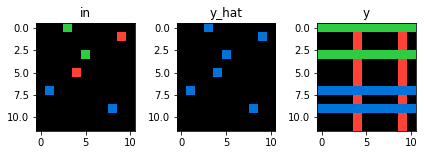

In [19]:
def apply_rule(rule, color_out, img):
    t = img.copy()
    for i, r in rule.iterrows():
        t[r.y][r.x] = color_out
    return t
    

def sibling_rule(data, child_key = 'parent_id', agg_key = 'class_id', c_props = None):
    
    temp = data.merge(data[[agg_key]+ [child_key]+ list(c_props.keys())], on=agg_key, how='left').drop_duplicates()
    
    xfilter= f"({child_key}_x != {child_key}_y)"
    for i in c_props:
        xfilter += f" & ({i}_y in {c_props.get(i)})"
    
    return temp.query(xfilter)[['x','y']]


def simple_rule(data, c_props = None):
    temp = data
    xfilter= ""
    for i in c_props:
        if i != 'color_out':
            xfilter += f" & ({i} in {c_props.get(i)})"
    
    return temp.query(xfilter[2:])[['x','y']]


imgo0 = task_sample_arr(TTT, test_train = 'test', in_out = 'input', idx = 0, path=training_path) #63613498
imgy = task_sample_arr(TTT, test_train = 'test', in_out = 'output', idx = 0, path=training_path) #63613498
oio0 = ObjectIndex(imgo0, kernel = k_plus(False), bg = 0)
oio0 = oio0.data
#oio0 = sibling_rule(oio0, child_key = 'parent_id', agg_key = 'class_id', c_props = c_prop_not_in_non_siblings(c_props, ti.all_non_siblings))#c_props)

img_out = imgo0.copy()
for c in ti.all_cmaps['color_out'].unique():
    sc_prop = common_prop(ti.all_diffs[ti.agg_features+['task','color_out']].drop_duplicates(), 
                          ti.num_tasks , 
                          given_props = {'color_out': str(c)})
    print('scp', sc_prop)
    #rule = simple_rule(oio0, c_props = sc_prop)
    #img_out = apply_rule(rule, c, img_out)
    rule = sibling_rule(oio0, child_key = 'parent_id', agg_key = 'class_id', c_props = c_prop_not_in_non_siblings(c_props, ti.all_non_siblings)) #c_props)
    img_out = apply_rule(rule, c, img_out)

fig, axs = plt.subplots(1, 3)#, figsize=(15,2*rows))
axs[0].imshow(imgo0, cmap=cmap, norm=cnorm)
axs[1].imshow(img_out, cmap=cmap, norm=cnorm)
axs[2].imshow(imgy, cmap=cmap, norm=cnorm)
axs[0].set_title('in')
axs[1].set_title('y_hat')
axs[2].set_title('y')
plt.tight_layout()
plt.show()

### 00576224 ###
### 009d5c81 ###
Accuracy: 0.8061224489795918


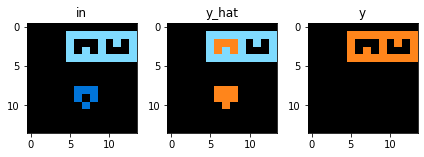

### 00dbd492 ###
Accuracy: 0.69


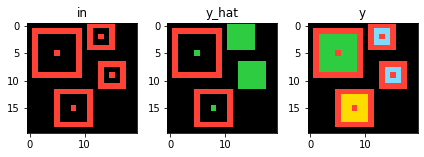

### 03560426 ###
Accuracy: 0.71


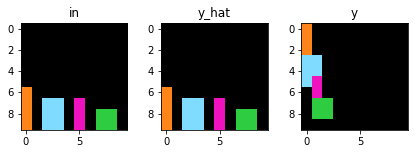

### 05a7bcf2 ###
### 0607ce86 ###
### 0692e18c ###
### 070dd51e ###
Accuracy: 0.8675


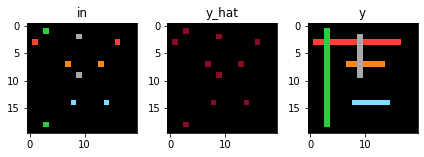

### 08573cc6 ###
Accuracy: 0.4556213017751479


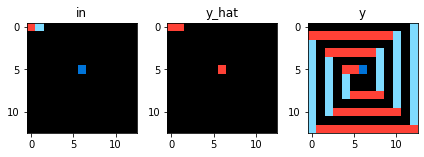

### 0934a4d8 ###
### 09c534e7 ###
Accuracy: 0.8522222222222222


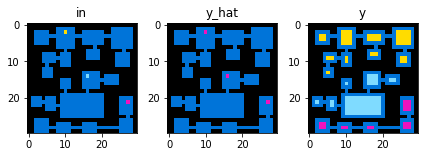

### 0a1d4ef5 ###
### 0a2355a6 ###
Accuracy: 0.5882352941176471


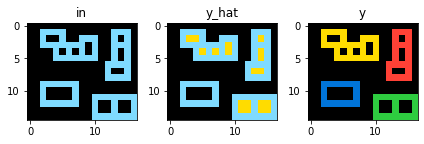

### 0b17323b ###
Accuracy: 0.9777777777777777


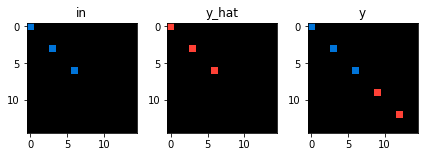

### 0bb8deee ###
### 0becf7df ###
Accuracy: 0.74


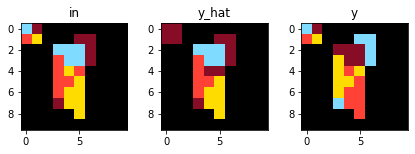

### 0c786b71 ###
### 0c9aba6e ###
### 0d87d2a6 ###
Accuracy: 0.6956521739130435


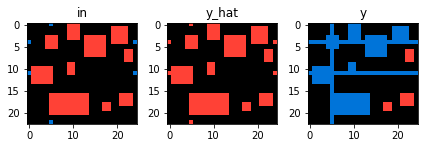

### 0e671a1a ###
Accuracy: 0.863905325443787


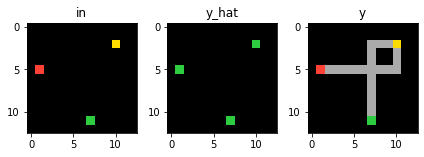

### 0f63c0b9 ###
Accuracy: 0.52


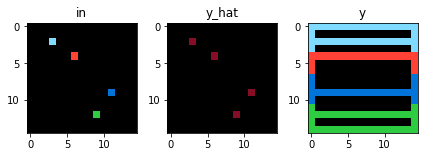

### 103eff5b ###
Accuracy: 0.7980769230769231


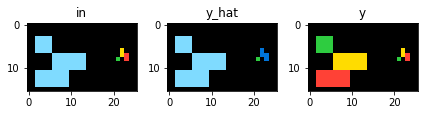

### 11e1fe23 ###
Accuracy: 0.9583333333333334


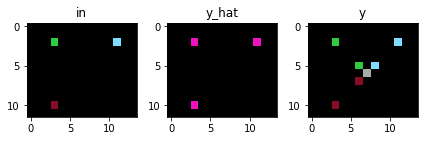

### 12422b43 ###
Accuracy: 0.8285714285714286


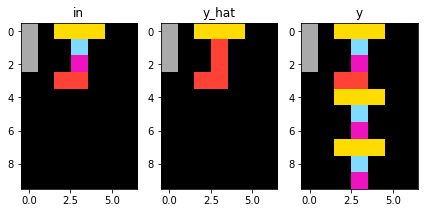

### 12997ef3 ###
### 12eac192 ###
Accuracy: 0.625


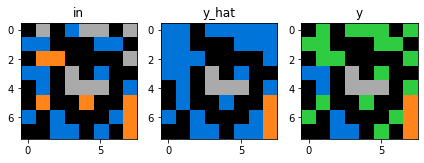

### 136b0064 ###
### 13713586 ###
Accuracy: 0.5175438596491229


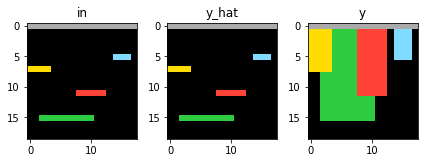

### 137f0df0 ###
Accuracy: 0.2


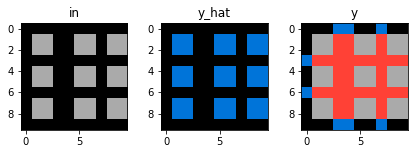

### 140c817e ###
### 14754a24 ###
### 15113be4 ###
Accuracy: 0.6786389413988658


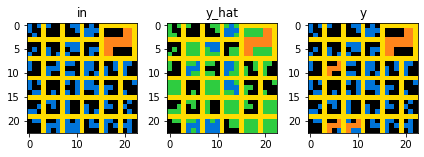

### 15663ba9 ###
Accuracy: 0.8666666666666667


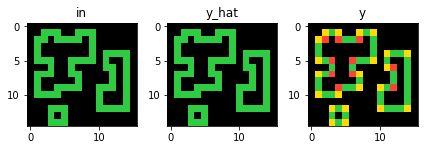

### 15696249 ###
### 16b78196 ###
Accuracy: 0.8922222222222222


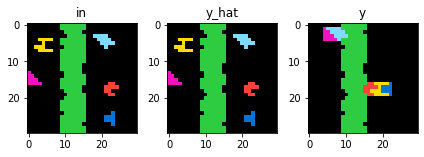

### 17b80ad2 ###
Accuracy: 0.7093425605536332


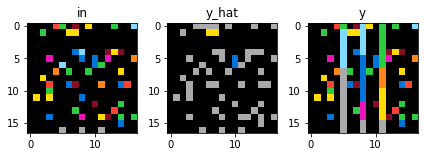

### 17cae0c1 ###
Accuracy: 0.1111111111111111


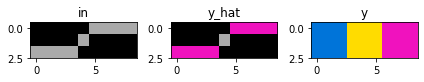

### 18419cfa ###
### 184a9768 ###
### 195ba7dc ###
### 1990f7a8 ###
### 19bb5feb ###
### 1a2e2828 ###
### 1a6449f1 ###
### 1acc24af ###
Accuracy: 0.9166666666666666


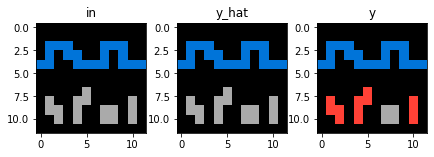

### 1c02dbbe ###
Accuracy: 0.4311111111111111


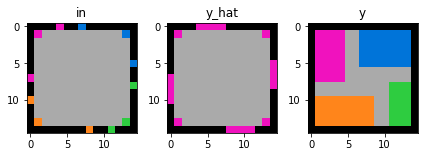

### 1c0d0a4b ###
Accuracy: 0.5266272189349113


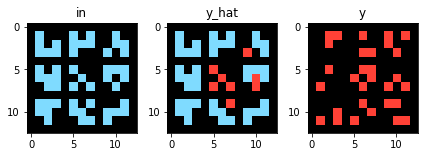

### 1c56ad9f ###
Accuracy: 0.6977777777777778


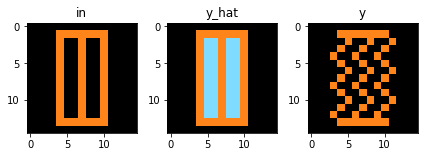

### 1d0a4b61 ###
### 1d398264 ###
Accuracy: 0.7847222222222222


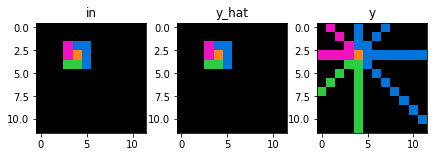

### 1da012fc ###
Accuracy: 0.9052631578947369


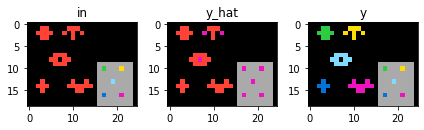

### 1e81d6f9 ###
Accuracy: 0.8755555555555555


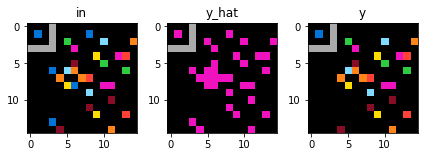

### 1e97544e ###
Accuracy: 0.502835538752363


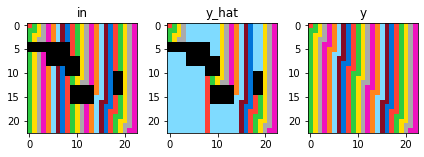

### 2037f2c7 ###
### 2072aba6 ###
### 20818e16 ###
### 20981f0e ###
Accuracy: 0.8461538461538461


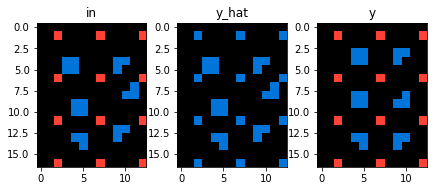

### 212895b5 ###
### 21f83797 ###
Accuracy: 0.5266272189349113


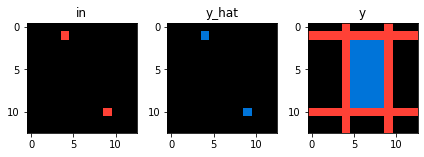

### 22a4bbc2 ###
Accuracy: 0.29545454545454547


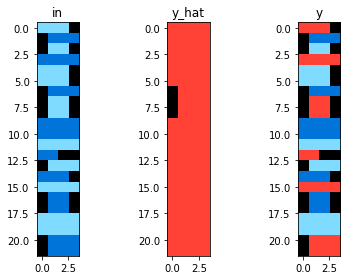

### 25094a63 ###
### 2546ccf6 ###
Accuracy: 0.6153846153846154


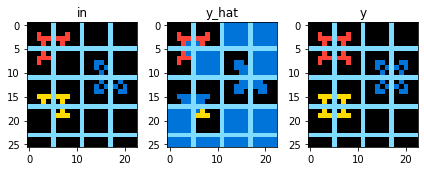

### 256b0a75 ###
### 2685904e ###
Accuracy: 0.47


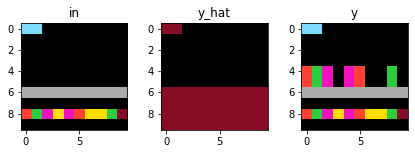

### 2697da3f ###
### 2753e76c ###
### 27a77e38 ###
Accuracy: 0.6419753086419753


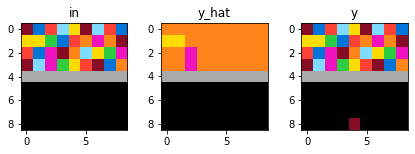

### 27f8ce4f ###
### 281123b4 ###
### 292dd178 ###
Accuracy: 0.8727272727272727


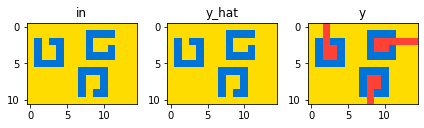

### 29700607 ###
Accuracy: 0.6942148760330579


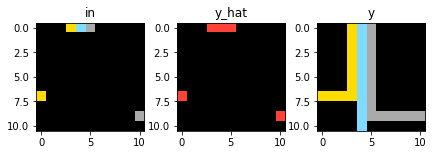

### 2a5f8217 ###
Accuracy: 0.8757396449704142


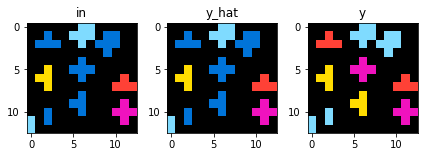

### 2b01abd0 ###
### 2c0b0aff ###
### 2c737e39 ###
Accuracy: 0.8636363636363636


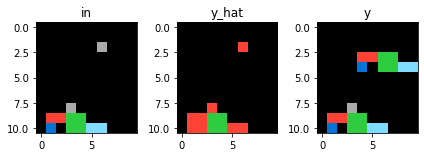

### 2f0c5170 ###
### 310f3251 ###
### 3194b014 ###
### 319f2597 ###
### 31adaf00 ###
Accuracy: 0.69


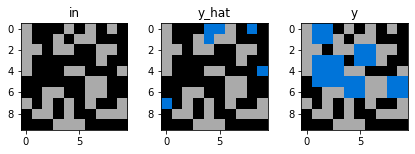

### 31d5ba1a ###
### 32e9702f ###
Accuracy: 0.12


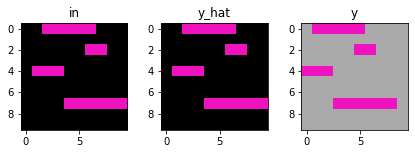

### 332efdb3 ###
Accuracy: 0.2066115702479339


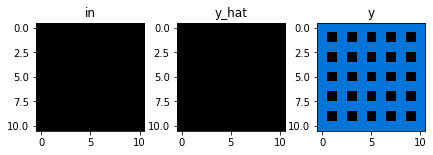

### 3391f8c0 ###
Accuracy: 0.7662337662337663


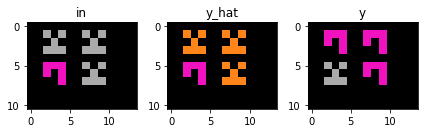

### 33b52de3 ###
Accuracy: 0.780718336483932


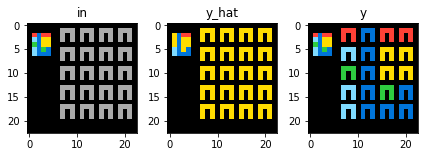

### 3490cc26 ###
Accuracy: 0.8142292490118577


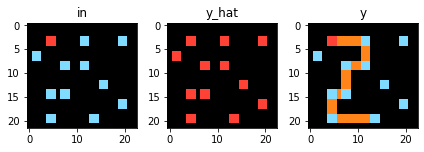

### 34b99a2b ###
### 351d6448 ###
### 358ba94e ###
### 37d3e8b2 ###
Accuracy: 0.46078431372549017


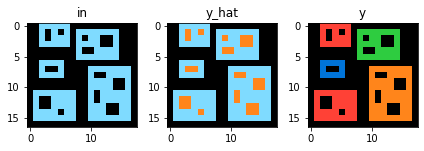

### 3979b1a8 ###
### 3a301edc ###
Accuracy: 0.63718820861678


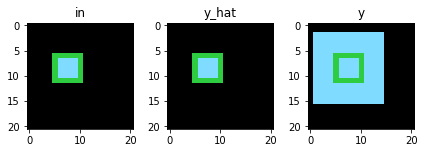

### 3b4c2228 ###
### 3d31c5b3 ###
### 3ed85e70 ###
### 3ee1011a ###
### 3f23242b ###
Accuracy: 0.7027863777089783


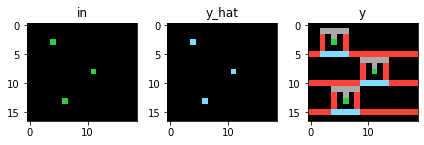

### 40f6cd08 ###
Accuracy: 0.6388888888888888


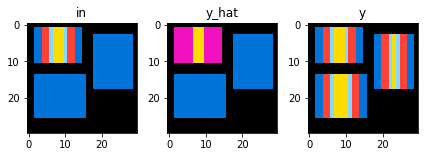

### 414297c0 ###
### 423a55dc ###
Accuracy: 0.8111888111888111


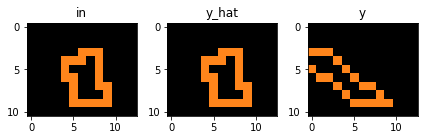

### 42918530 ###
Accuracy: 0.5376


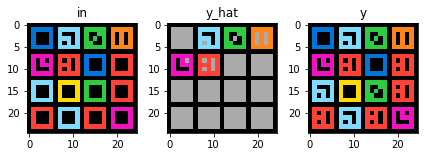

### 42a15761 ###
Accuracy: 0.9617224880382775


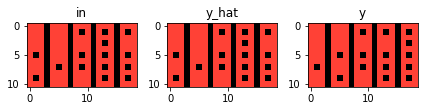

### 4364c1c4 ###
Accuracy: 0.8901098901098901


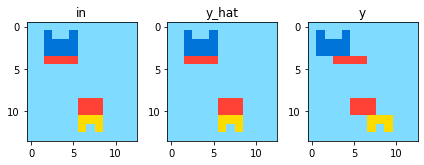

### 456873bc ###
Accuracy: 0.7673130193905817


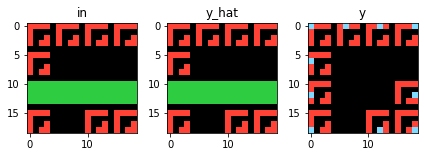

### 45737921 ###
Accuracy: 0.75


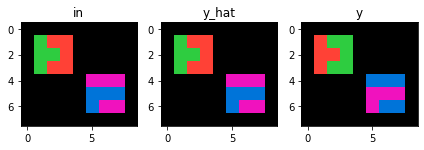

### 45bbe264 ###
### 477d2879 ###
Accuracy: 0.0


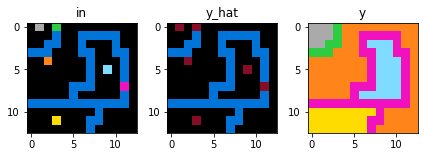

### 47996f11 ###
### 48131b3c ###
### 4852f2fa ###
### 48f8583b ###
### 4aab4007 ###
Accuracy: 0.15306122448979592


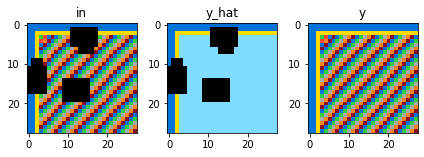

### 4acc7107 ###
Accuracy: 0.57


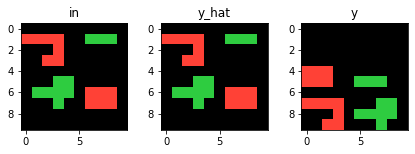

### 4b6b68e5 ###
Accuracy: 0.7532051282051282


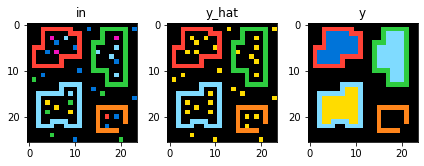

### 4c177718 ###
### 4cd1b7b2 ###
Accuracy: 0.1875


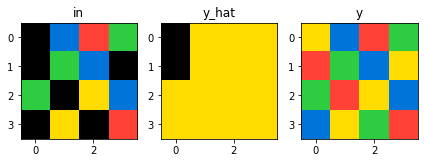

### 4e45f183 ###
Accuracy: 0.817174515235457


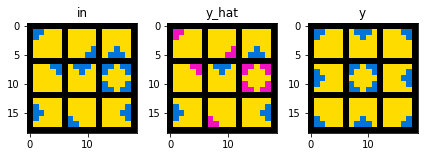

### 4e469f39 ###
Accuracy: 0.8


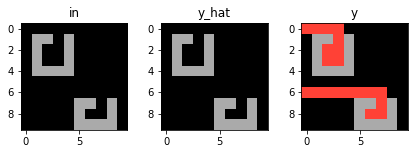

### 4f537728 ###
### 4ff4c9da ###
Accuracy: 1.0


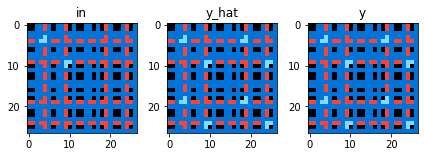

### 505fff84 ###
### 506d28a5 ###
### 50a16a69 ###
Accuracy: 0.3333333333333333


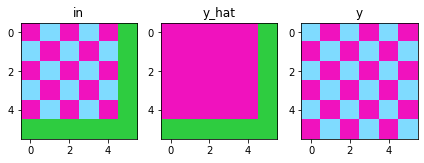

### 50aad11f ###
Accuracy: 0.7485207100591716


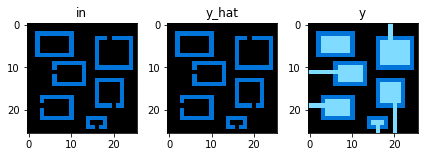

### 55783887 ###
Accuracy: 0.8914473684210527


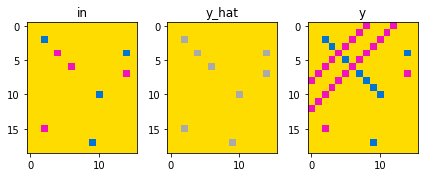

### 575b1a71 ###
### 5783df64 ###
### 5833af48 ###
### 58743b76 ###
### 58e15b12 ###
Accuracy: 0.8395833333333333


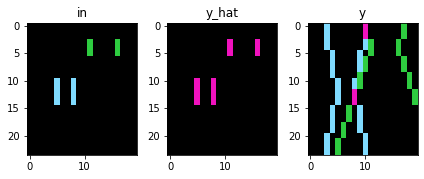

### 59341089 ###
### 5a5a2103 ###
Accuracy: 0.3888888888888889


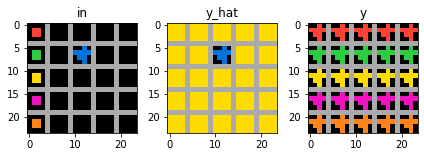

### 5af49b42 ###
Accuracy: 0.8888888888888888


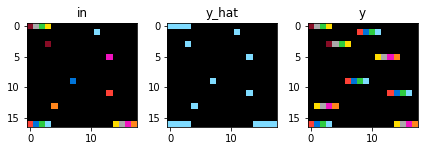

### 5b526a93 ###
Accuracy: 0.7333333333333333


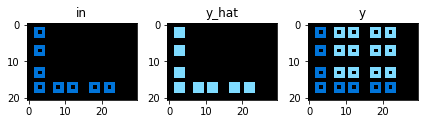

### 5b692c0f ###
### 5b6cbef5 ###
### 5d2a5c43 ###
### 5ffb2104 ###
Accuracy: 0.59


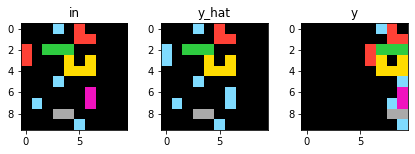

### 604001fa ###
Accuracy: 0.75


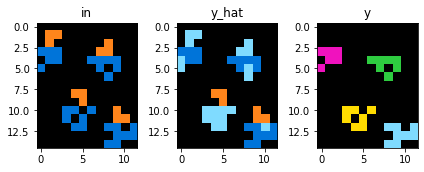

### 60a26a3e ###
Accuracy: 0.8074074074074075


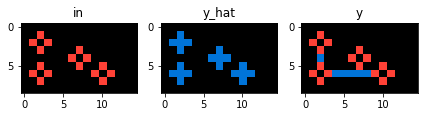

### 60c09cac ###
### 626c0bcc ###
Accuracy: 0.6122448979591837


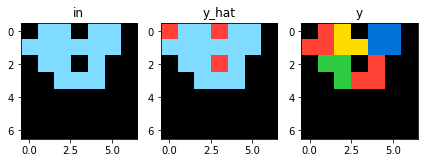

### 62ab2642 ###
Accuracy: 0.8


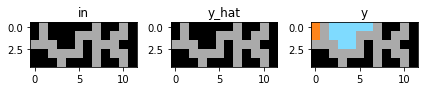

### 62b74c02 ###
Accuracy: 0.07142857142857142


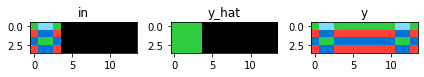

### 639f5a19 ###
Accuracy: 0.553875236294896


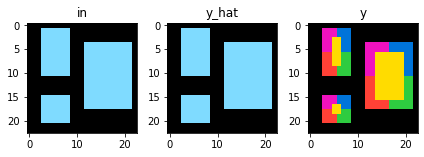

### 642248e4 ###
Accuracy: 0.8055555555555556


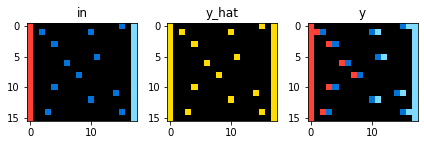

### 642d658d ###
### 64a7c07e ###
Accuracy: 0.7638888888888888


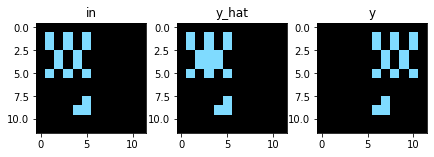

### 66e6c45b ###
Accuracy: 0.5


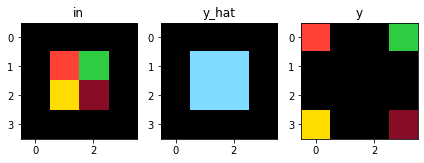

### 66f2d22f ###
### 67636eac ###
### 67b4a34d ###
### 67c52801 ###
Accuracy: 0.6363636363636364


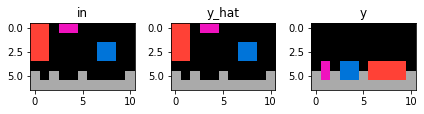

### 68b67ca3 ###
### 692cd3b6 ###
### 695367ec ###
### 696d4842 ###
Accuracy: 0.96


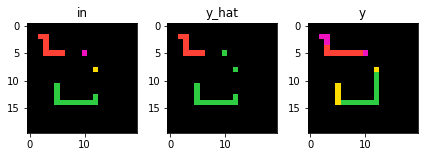

### 69889d6e ###
Accuracy: 0.85


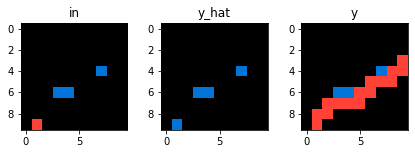

### 6a11f6da ###
### 6ad5bdfd ###
Accuracy: 0.65


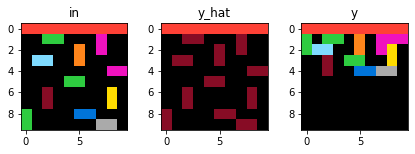

### 6df30ad6 ###
Accuracy: 0.75


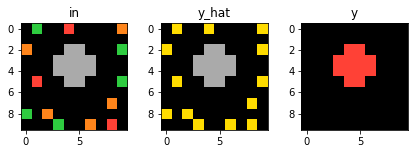

### 6ea4a07e ###
Accuracy: 0.0


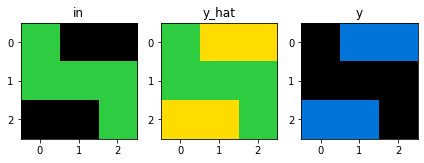

### 6f473927 ###
### 7039b2d7 ###
### 705a3229 ###
### 712bf12e ###
### 72207abc ###
Accuracy: 0.9195402298850575


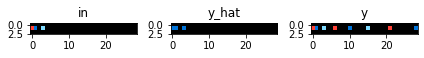

### 72a961c9 ###
Accuracy: 0.797979797979798


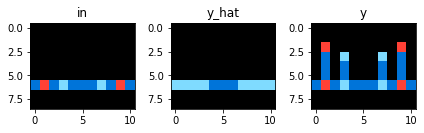

### 73182012 ###
### 73c3b0d8 ###
Accuracy: 0.9166666666666666


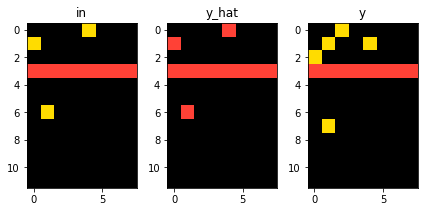

### 73ccf9c2 ###
### 759f3fd3 ###
Accuracy: 0.5694444444444444


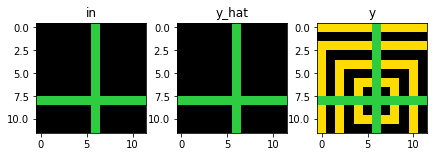

### 762cd429 ###
### 770cc55f ###
Accuracy: 0.6727272727272727


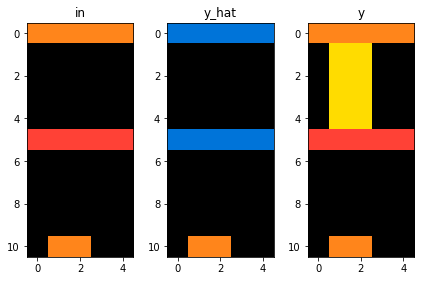

### 782b5218 ###
Accuracy: 0.51


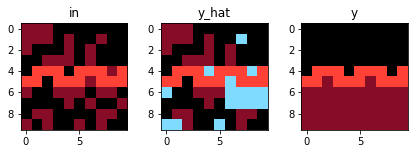

### 79369cc6 ###
### 7953d61e ###
### 79fb03f4 ###
Accuracy: 0.6804733727810651


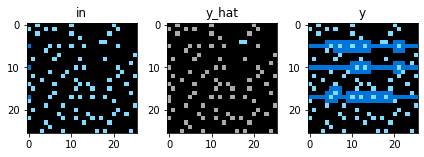

### 7bb29440 ###
### 7c8af763 ###
Accuracy: 0.58


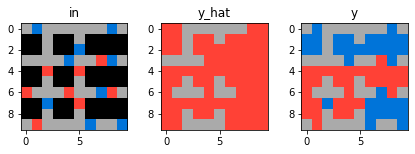

### 7c9b52a0 ###
### 7d18a6fb ###
### 7d1f7ee8 ###
Accuracy: 0.8201970443349754


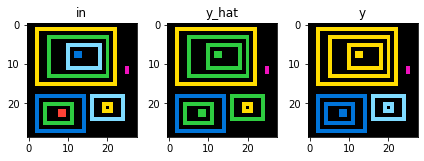

### 7d419a02 ###
### 7e02026e ###
Accuracy: 0.7569444444444444


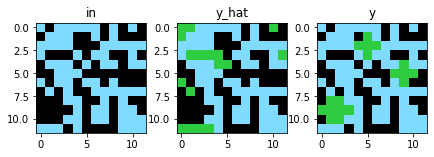

### 7ee1c6ea ###
### 817e6c09 ###
### 81c0276b ###
### 833dafe3 ###
### 845d6e51 ###
Accuracy: 0.8660130718954249


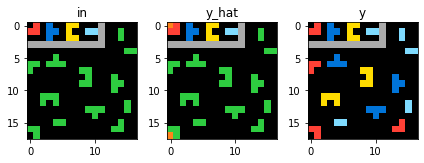

### 84db8fc4 ###
### 84f2aca1 ###
Accuracy: 0.8012820512820513


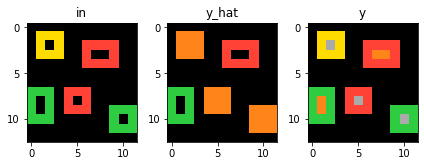

### 8597cfd7 ###
### 85b81ff1 ###
Accuracy: 0.8846153846153846


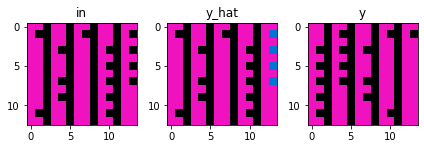

### 85fa5666 ###
### 8719f442 ###
### 88207623 ###
### 891232d6 ###
Accuracy: 0.7748148148148148


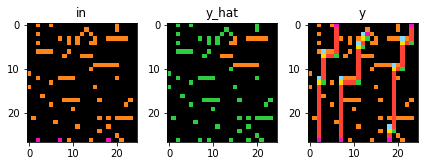

### 896d5239 ###
Accuracy: 0.7407407407407407


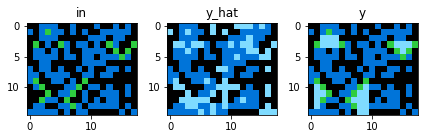

### 8a371977 ###
Accuracy: 0.7155555555555555


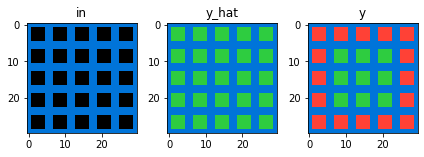

### 8b28cd80 ###
### 8ba14f53 ###
### 8cb8642d ###
### 8dae5dfc ###
Accuracy: 0.45526315789473687


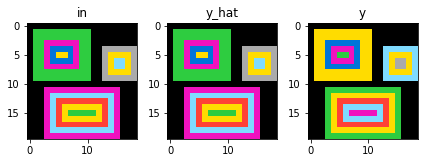

### 8e2edd66 ###
### 8ee62060 ###
Accuracy: 0.7448979591836735


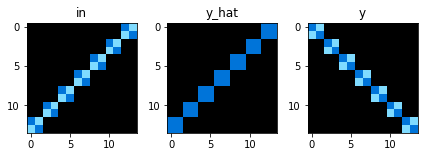

### 8fbca751 ###
Accuracy: 0.7395833333333334


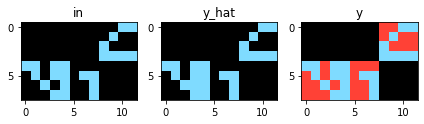

### 90347967 ###
Accuracy: 0.7901234567901234


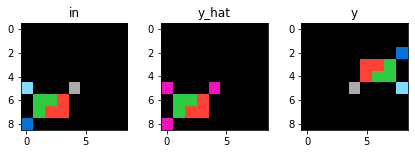

### 903d1b4a ###
### 9110e3c5 ###
### 917bccba ###
### 929ab4e9 ###
### 92e50de0 ###
Accuracy: 0.49108204518430437


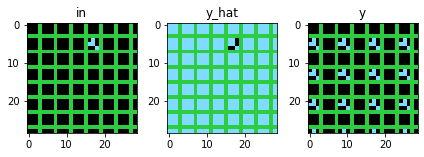

### 9356391f ###
Accuracy: 0.73046875


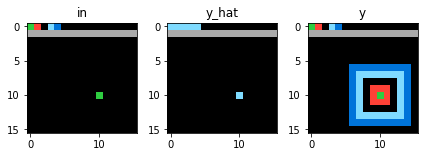

### 93b4f4b3 ###
### 93c31fbe ###
Accuracy: 0.8626373626373627


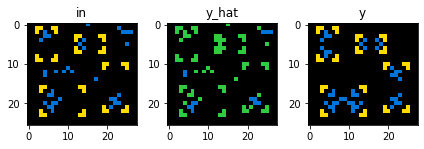

### 94133066 ###
### 94414823 ###
Accuracy: 0.82


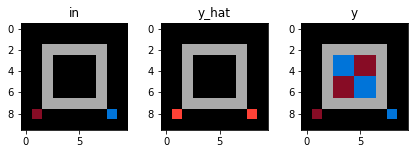

### 94be5b80 ###
Accuracy: 0.7851851851851852


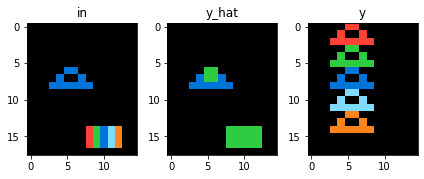

### 95a58926 ###
### 963f59bc ###
### 96a8c0cd ###
Accuracy: 0.8514588859416445


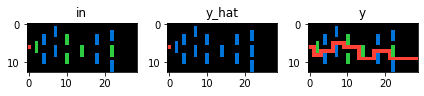

### 97239e3d ###
Accuracy: 0.3079584775086505


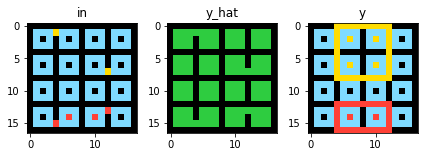

### 9772c176 ###
Accuracy: 0.93


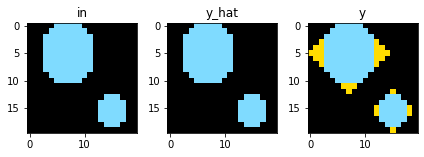

### 981571dc ###
### 992798f6 ###
Accuracy: 0.953125


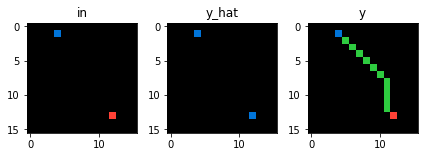

### 99306f82 ###
Accuracy: 0.66


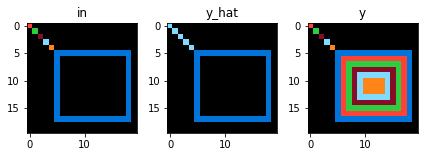

### 9a4bb226 ###
### 9b2a60aa ###
Accuracy: 0.9102564102564102


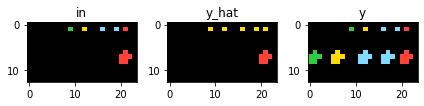

### 9b365c51 ###
Accuracy: 0.30612244897959184


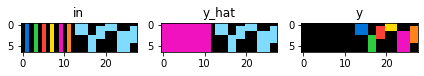

### 9b4c17c4 ###
Accuracy: 0.7636363636363637


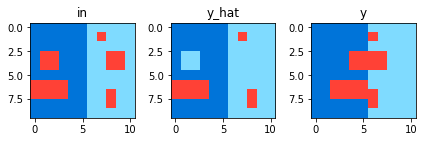

### 9bebae7a ###
Accuracy: 0.8863636363636364


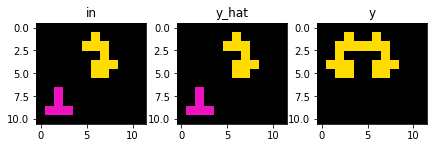

### 9c1e755f ###
Accuracy: 0.58


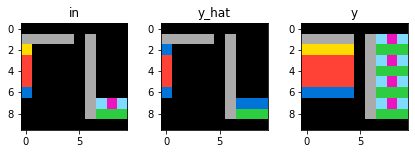

### 9c56f360 ###
Accuracy: 0.7037037037037037


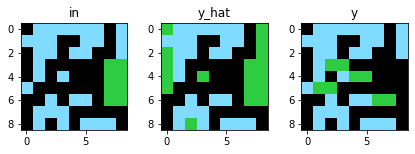

### 9caba7c3 ###
Accuracy: 0.6897506925207756


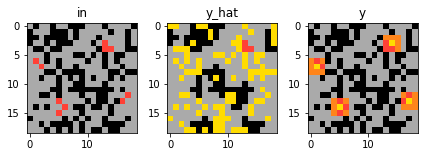

### 9ddd00f0 ###
Accuracy: 0.6066481994459834


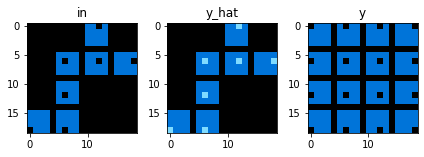

### 9def23fe ###
Accuracy: 0.695


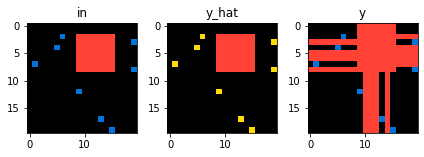

### 9f27f097 ###
### a04b2602 ###
Accuracy: 0.6944444444444444


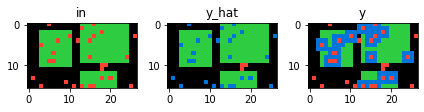

### a096bf4d ###
Accuracy: 0.40828402366863903


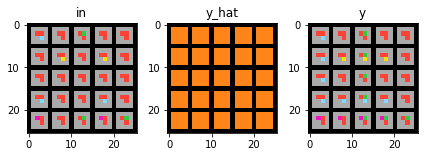

### a3f84088 ###
Accuracy: 0.5455555555555556


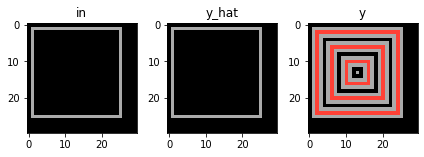

### a406ac07 ###
### a57f2f04 ###
Accuracy: 0.8426573426573427


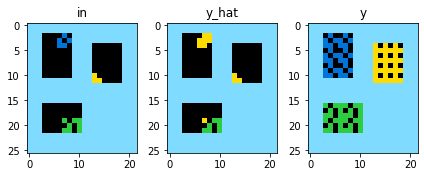

### a59b95c0 ###
### a680ac02 ###
### a8610ef7 ###
Accuracy: 0.5833333333333334


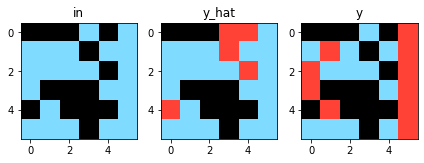

### a934301b ###
Accuracy: 0.6923076923076923


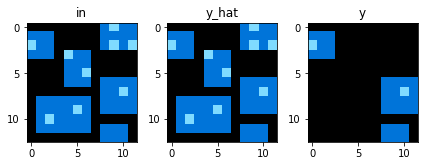

### aa18de87 ###
Accuracy: 0.3888888888888889


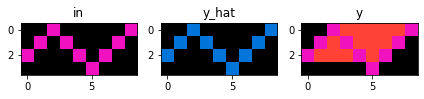

### aa300dc3 ###
Accuracy: 0.93


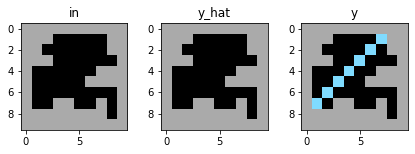

### aa4ec2a5 ###
Accuracy: 0.6552706552706553


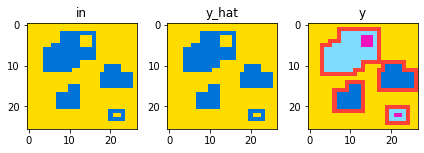

### aab50785 ###
### ac0c5833 ###
### ac2e8ecf ###
Accuracy: 0.6166666666666667


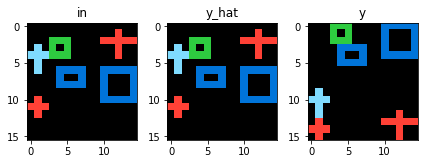

### ac3e2b04 ###
### ac605cbb ###
Accuracy: 0.8181818181818182


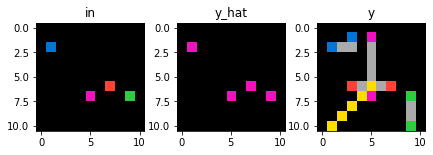

### ad7e01d0 ###
### ae58858e ###
Accuracy: 0.7708333333333334


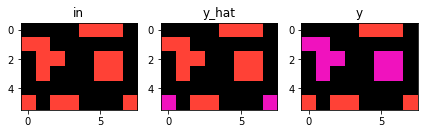

### aee291af ###
### af22c60d ###
Accuracy: 0.43666666666666665


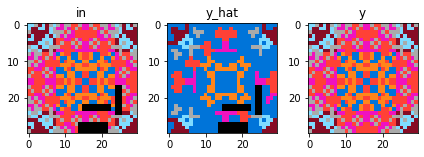

### af24b4cc ###
### b0722778 ###
### b0f4d537 ###
### b15fca0b ###
Accuracy: 0.46


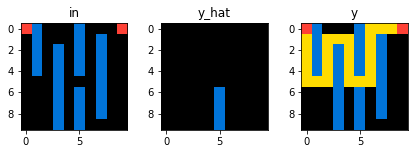

### b1fc8b8e ###
### b20f7c8b ###
Accuracy: 0.7373737373737373


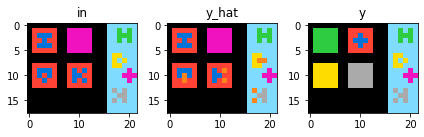

### b457fec5 ###
Accuracy: 0.6859903381642513


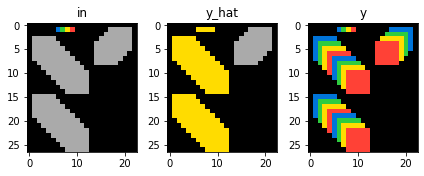

### b4a43f3b ###
### b7999b51 ###
### b7cb93ac ###
### b7f8a4d8 ###
Accuracy: 0.4444444444444444


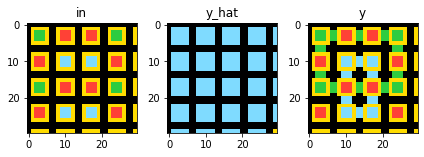

### b7fb29bc ###
Accuracy: 0.7866666666666666


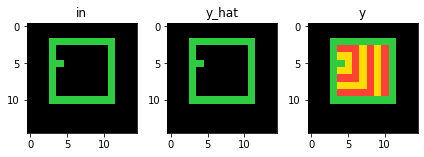

### b942fd60 ###
### b9630600 ###
Accuracy: 0.9322222222222222


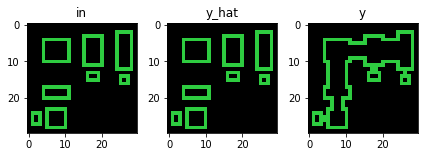

### ba9d41b8 ###
Accuracy: 0.8088642659279779


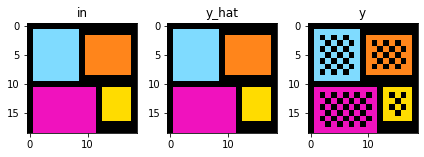

### baf41dbf ###
Accuracy: 0.8125


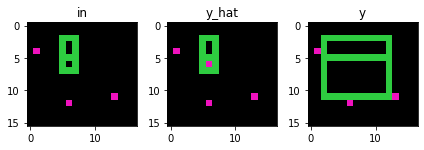

### bb52a14b ###
Accuracy: 0.8181818181818182


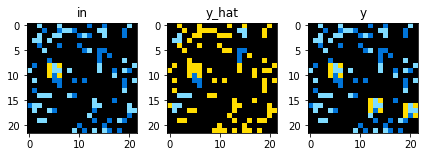

### bbb1b8b6 ###
### bc4146bd ###
### bcb3040b ###
### bd14c3bf ###
Accuracy: 0.7839335180055401


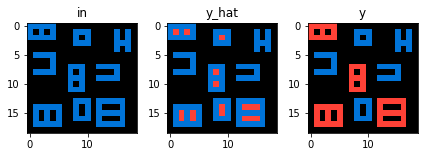

### be03b35f ###
### bf32578f ###
Accuracy: 0.625


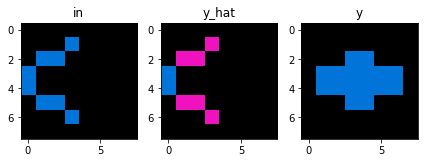

### bf699163 ###
### bf89d739 ###
Accuracy: 0.8949579831932774


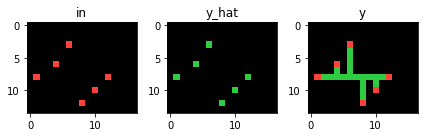

### c074846d ###
Accuracy: 0.9259259259259259


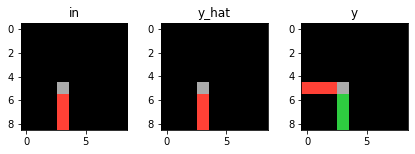

### c1990cce ###
### c3202e5a ###
### c35c1b4c ###
Accuracy: 0.62


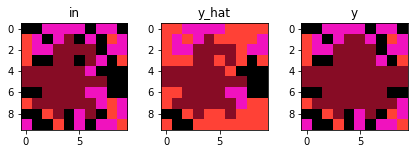

### c48954c1 ###
### c62e2108 ###
Accuracy: 0.6944444444444444


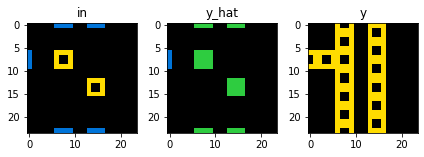

### c64f1187 ###
### c658a4bd ###
### c663677b ###
### c6e1b8da ###
Accuracy: 0.8275


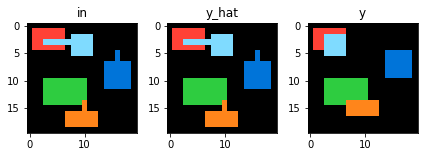

### c7d4e6ad ###
Accuracy: 0.79


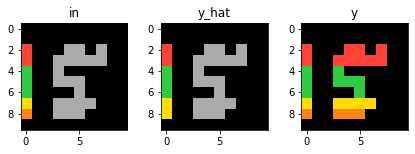

### c87289bb ###
### c8b7cc0f ###
### c92b942c ###
### c97c0139 ###
Accuracy: 0.8484848484848485


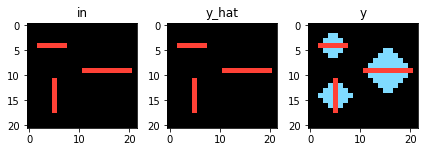

### ca8de6ea ###
### ca8f78db ###
Accuracy: 0.56


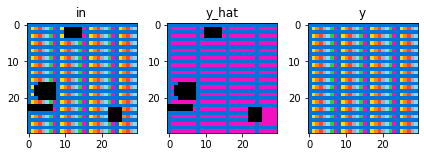

### cad67732 ###
### cb227835 ###
Accuracy: 0.8791208791208791


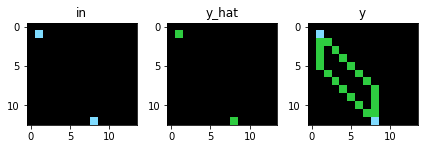

### ccd554ac ###
### cd3c21df ###
### ce039d91 ###
Accuracy: 0.82


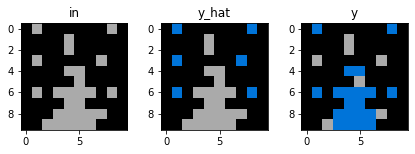

### ce8d95cc ###
### cf133acc ###
Accuracy: 0.7555555555555555


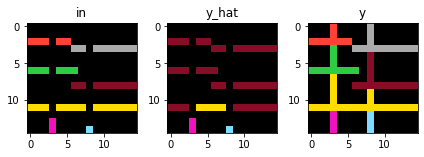

### cfb2ce5a ###
Accuracy: 0.59


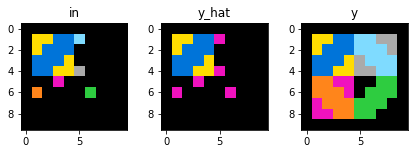

### d017b73f ###
### d19f7514 ###
### d282b262 ###
Accuracy: 0.5866666666666667


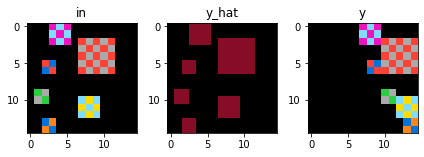

### d2acf2cb ###
### d304284e ###
Accuracy: 0.9006211180124224


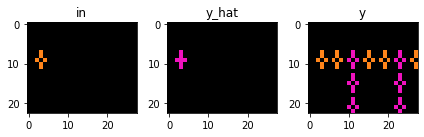

### d37a1ef5 ###
Accuracy: 0.7884615384615384


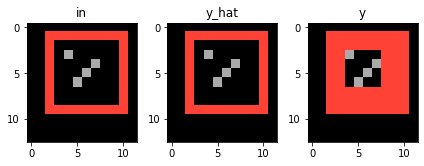

### d47aa2ff ###
### d492a647 ###
Accuracy: 0.7411764705882353


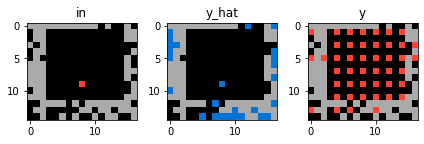

### d4b1c2b1 ###


/opt/conda/envs/fastai/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
/opt/conda/envs/fastai/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
/opt/conda/envs/fastai/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and 

### d4c90558 ###
### d56f2372 ###
### d5c634a2 ###
### d931c21c ###


/opt/conda/envs/fastai/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
/opt/conda/envs/fastai/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
/opt/conda/envs/fastai/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and 

Accuracy: 0.8555555555555555


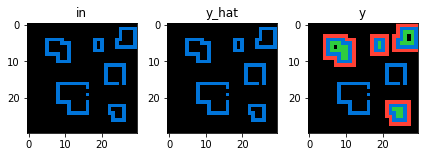

### d94c3b52 ###
### da2b0fe3 ###
Accuracy: 0.9


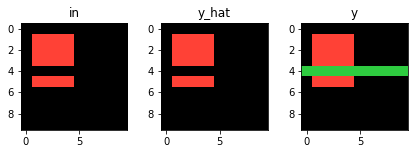

### da515329 ###
Accuracy: 0.5251479289940828


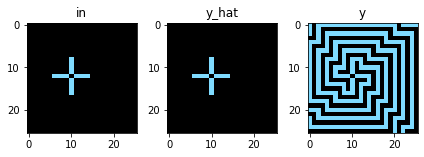

### dc2aa30b ###
Accuracy: 0.6694214876033058


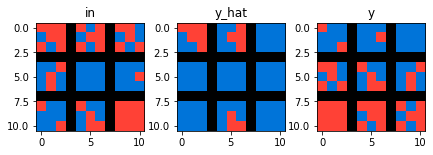

### dc2e9a9d ###
### dd2401ed ###
Accuracy: 0.8095238095238095


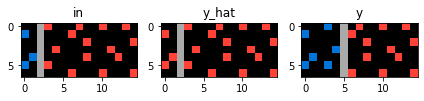

### de493100 ###
### df8cc377 ###
Accuracy: 0.8496503496503497


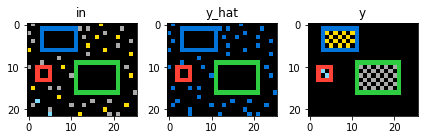

### e0fb7511 ###
Accuracy: 0.6745562130177515


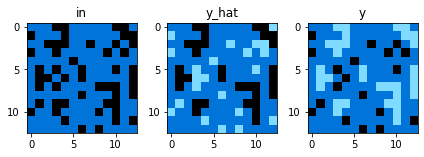

### e133d23d ###
### e1baa8a4 ###
### e1d2900e ###
Accuracy: 0.96


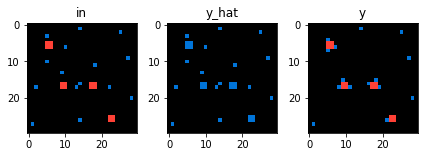

### e2092e0c ###
Accuracy: 0.6133333333333333


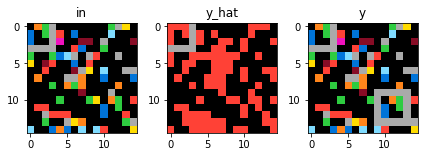

### e21a174a ###
Accuracy: 0.5918367346938775


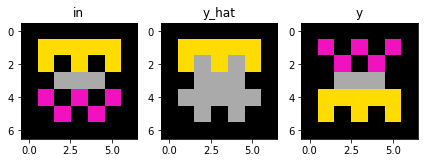

### e345f17b ###
### e4075551 ###
### e41c6fd3 ###
Accuracy: 0.8137254901960784


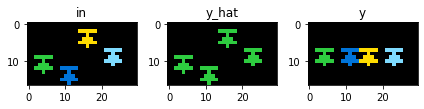

### e57337a4 ###
### e5790162 ###
Accuracy: 0.825


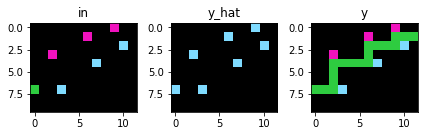

### e5c44e8f ###
Accuracy: 0.9504132231404959


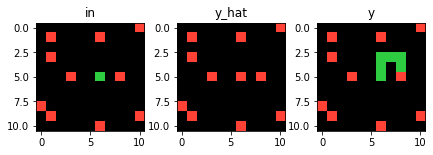

### e619ca6e ###
Accuracy: 0.874384236453202


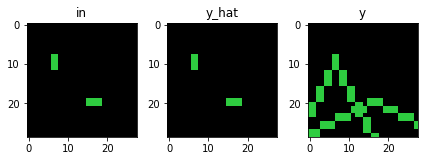

### e633a9e5 ###
### e66aafb8 ###
### e681b708 ###
### e69241bd ###
### e6de6e8f ###
### e74e1818 ###
Accuracy: 0.7777777777777778


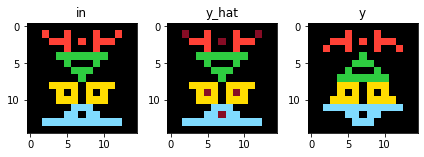

### e760a62e ###
Accuracy: 0.35714285714285715


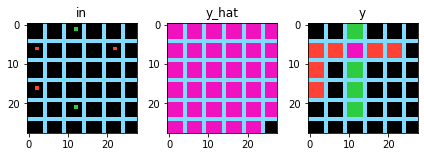

### e7639916 ###
Accuracy: 0.8131868131868132


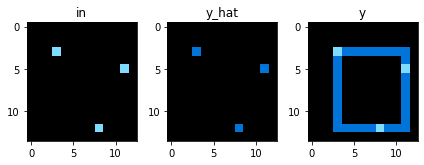

### e78887d1 ###
### e7a25a18 ###
### e7b06bea ###
Accuracy: 0.5555555555555556


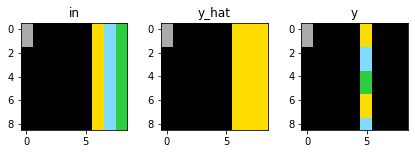

### e7dd8335 ###
### e872b94a ###
### e88171ec ###
Accuracy: 0.7936507936507936


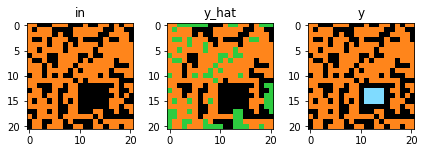

### e95e3d8e ###
### e99362f0 ###
### e9ac8c9e ###
Accuracy: 0.6977777777777778


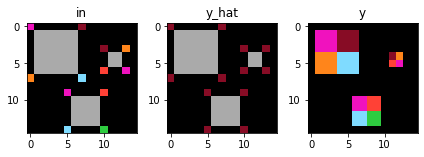

### e9b4f6fc ###
### e9bb6954 ###
Accuracy: 0.5983379501385041


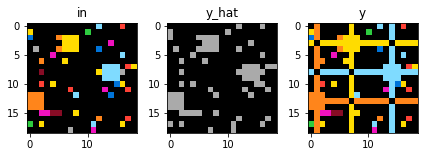

### e9c9d9a1 ###
### ea959feb ###
Accuracy: 0.10727272727272727


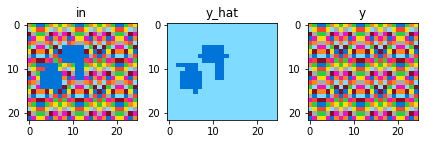

### ea9794b1 ###
### ecaa0ec1 ###
Accuracy: 0.9256198347107438


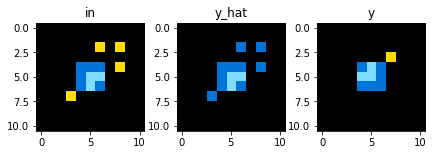

### ed74f2f2 ###
### ed98d772 ###
### ef26cbf6 ###
### f0afb749 ###
### f0df5ff0 ###
Accuracy: 0.3422222222222222


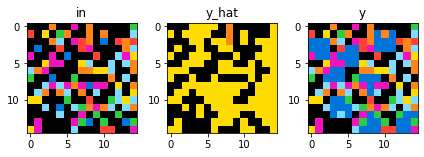

### f21745ec ###
### f3b10344 ###
Accuracy: 0.7827586206896552


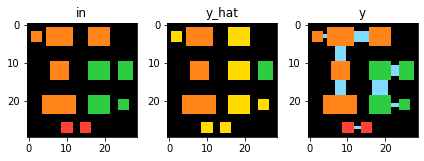

### f3cdc58f ###
### f3e62deb ###
Accuracy: 0.84


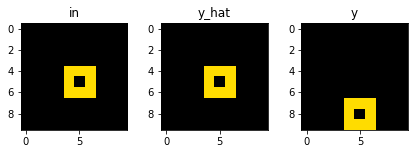

### f4081712 ###
### f45f5ca7 ###
Accuracy: 0.84


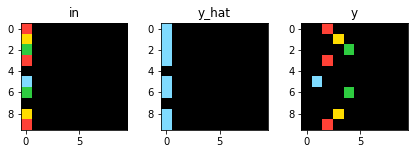

### f5aa3634 ###
### f5c89df1 ###
Accuracy: 0.8224852071005917


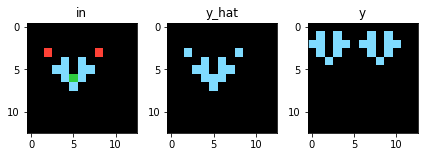

### f823c43c ###
### f83cb3f6 ###
Accuracy: 0.82


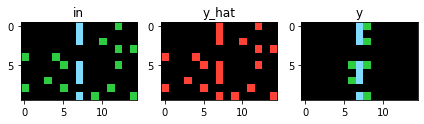

### f8be4b64 ###
Accuracy: 0.7091412742382271


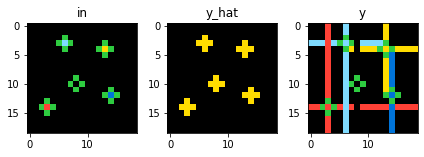

### f9a67cb5 ###
Accuracy: 0.7238095238095238


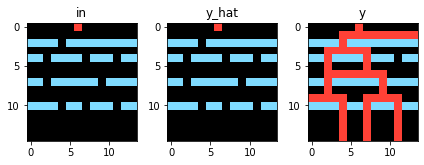

### f9d67f8b ###
### fafd9572 ###
Accuracy: 0.8273809523809523


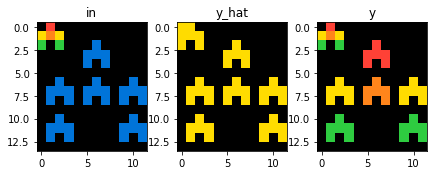

### fb791726 ###
### fc754716 ###
Accuracy: 0.5396825396825397


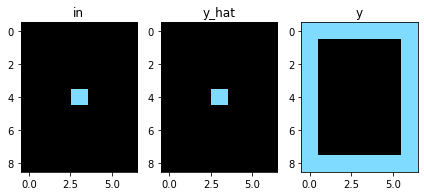

### fd096ab6 ###
Accuracy: 0.9444444444444444


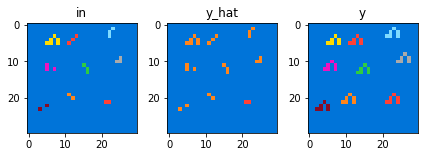

### fd4b2b02 ###
Accuracy: 0.875


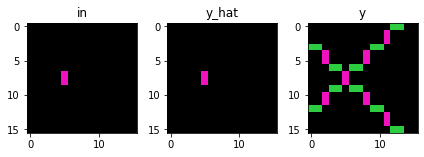

### fe9372f3 ###
Accuracy: 0.8568627450980392


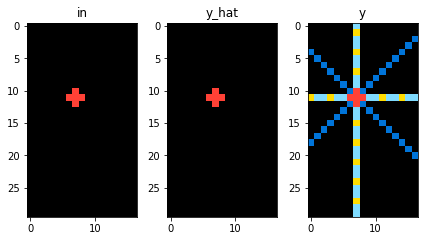

### fea12743 ###
Accuracy: 0.7727272727272727


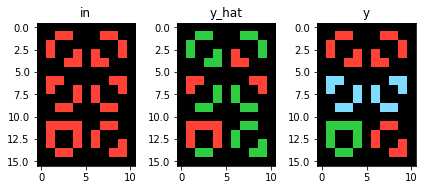

### ff72ca3e ###
Accuracy: 0.6633333333333333


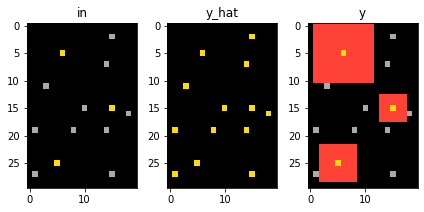

In [20]:
def run_task(taskname='63613498', path=training_path, c_bg = None):
    ##TTT = '810b9b61' #'63613498' # '776ffc46' #'7df24a62' # e509e548 #ea32f347 e8593010

    print(f'### {taskname} ###')
    
    kernel = k_plus(False)
    
    ti = TaskIndex(taskname, kernel = kernel, path=path, c_bg = c_bg) # 63613498 776ffc46
    c_props = common_prop(ti.all_siblings, num_tasks = ti.num_tasks)#, given_props = {'color_out':'2'})

    imgo0 = task_sample_arr(taskname, test_train = 'test', in_out = 'input', idx = 0, path=path) #63613498
    
     
    imgy = task_sample_arr(taskname, test_train = 'test', in_out = 'output', idx = 0, path=path) #63613498
    
    if imgo0.shape!=imgo0.shape:
        return
    
    oio0 = ObjectIndex(imgo0, kernel = kernel, bg = c_bg)
    oio0 = oio0.data
    #img_out = sibling_rule(oio0, child_key = 'parent_id', agg_key = 'class_id', c_props = c_prop_not_in_non_siblings(c_props, ti.all_non_siblings))#c_props)

    img_out = imgo0.copy()
    for c in ti.all_cmaps['color_out'].unique():
        sc_prop = common_prop(ti.all_diffs[ti.agg_features+['task','color_out']].drop_duplicates(), 
                              ti.num_tasks , 
                              given_props = {'color_out': str(c)})
        ##print('scp', sc_prop)
        #rule = simple_rule(oio0, c_props = sc_prop)
        rule = sibling_rule(oio0, child_key = 'parent_id', agg_key = 'class_id', c_props = c_prop_not_in_non_siblings(c_props, ti.all_non_siblings))#c_props)
        img_out = apply_rule(rule, c, img_out)

    acc = metrics.accuracy_score(imgy.reshape(1,-1)[0], img_out.reshape(1,-1)[0])
    print(f'Accuracy: {acc}')
    
    fig, axs = plt.subplots(1, 3)#, figsize=(15,2*rows))
    axs[0].imshow(imgo0, cmap=cmap, norm=cnorm)
    axs[1].imshow(img_out, cmap=cmap, norm=cnorm)
    axs[2].imshow(imgy, cmap=cmap, norm=cnorm)
    axs[0].set_title('in')
    axs[1].set_title('y_hat')
    axs[2].set_title('y')
    plt.tight_layout()
    plt.show()


training_tasks = sorted(os.listdir(evaluation_path)) #training_path
training_tasks = [i.split('.')[0] for i in training_tasks]

training_tasks = training_tasks[1:] #[-201:-101]

for taskname in training_tasks:
    try:
        run_task(taskname,path=evaluation_path, c_bg=77)
    except:
        None #print(f'Error!')

In [21]:
print('ok')

ok


In [22]:
                

## Test
p_agg_features=['color',#'parent_id', 'grandparent_id', 
                'p_bbox_width', 'p_bbox_height',
          'class_id_norm','class_id',
       'class_id_gp_norm', 
       'obj_per_gparent', 'classes_per_gpclass',
       'rotations_per_class','class_rotation', 'class_rotation_gp',
       'boxed_by_class_id', 'boxed_by_class_id_incl_bg',
               'o_p_cnt_rank',	'o_c_cnt_rank',	'p_c_cnt_rank']

p_agg_key = 'class_id' # _0

all_data = None

all_diffs = None
all_siblings=None
all_non_siblings=None
all_cmaps=None

num_tasks = 4
for i in range(num_tasks):
    imgi0 = task_sample_arr('776ffc46', test_train = 'train', in_out = 'input', idx = i, path=training_path)
    oii0 = ObjectIndex(imgi0, kernel = k_plus(False), bg = 0)

    imgo0 = task_sample_arr('776ffc46', test_train = 'train', in_out = 'output', idx = i, path=training_path)
    oio0 = ObjectIndex(imgo0, kernel = k_plus(False), bg = 0)

    ## Rules: Frame keeps color
    ic0 = IdxComperator(oii0, oio0)
    #63613498 #ddf7fa4f #776ffc46
    
    _,diff_columns,cmap_xy = ic0.diff()

    cmap_xy['task'] = i
    if isinstance(all_cmaps,pd.DataFrame):
        all_cmaps = all_cmaps.append(cmap_xy)
    else:
        all_cmaps = cmap_xy
        

    if isinstance(all_data,pd.DataFrame):
        all_data = all_data.append(oii0.data.merge(oio0.data[['x','y','color']], on=['x','y'], how='left'))
    else:
        all_data = oii0.data.merge(oio0.data[['x','y','color']], on=['x','y'], how='left')
    
    #for m in ic0.interpreter():
    #    print(m)

    # CMAP
        # Only keep changed x,y    
    m = oii0.data.merge(cmap_xy, on = ['x', 'y'], how = 'inner')
    if isinstance(all_diffs, pd.DataFrame):
        all_diffs = all_diffs.append(m)
    else:    
        all_diffs = m


    siblings = oii0.siblings(xy_filter = cmap_xy, child_key = 'parent_id', agg_key = 'class_id', agg_features = p_agg_features)
    
    siblings['task'] = i
    if isinstance(all_siblings, pd.DataFrame):
        all_siblings = all_siblings.append(siblings)
    else:    
        all_siblings = siblings
        
        
    non_siblings = oii0.non_siblings(child_key = 'parent_id', agg_key = 'class_id', agg_features = p_agg_features)
    
    non_siblings['task'] = i
    if isinstance(all_non_siblings, pd.DataFrame):
        all_non_siblings = all_non_siblings.append(non_siblings)
    else:    
        all_non_siblings = non_siblings


## shared property

c_props = common_prop(all_siblings, num_tasks)
print('c_props',c_props)
print('allns',all_non_siblings)

        
pd.options.display.max_rows = 150

all_siblings.T#nunique(axis=0)

#==>fount unique identifier
#all_cmaps
#diff_columns,

#all_siblings.T

    
print('c_props not in non_siblings',c_prop_not_in_non_siblings(c_props, all_non_siblings, DEBUG=DEBUG))
        
#c_props, common_prop(all_siblings, num_tasks, {'color_out': [5],
# 'class_rotation': [0],
# 'class_rotation_gp': [0],
#  'boxed_by_class_id': [' 0 0 0 1 0 2 0 3 1 0 2 0 3 0']
 #})
all_diffs[p_agg_features+['task','parent_id', 'color_out']].drop_duplicates().T

# single common_prop
print('scp',common_prop(all_diffs[p_agg_features+['task','parent_id', 'color_out']].drop_duplicates(), num_tasks))


# SIBLING UNIQUE FEATURES

all_data = all_data.merge(all_data[[p_agg_key]+['boxed_by_class_id']], on=p_agg_key, how='left').drop_duplicates().reset_index(drop = True)


all_diffs[p_agg_features+['task','parent_id', 'color_out']].drop_duplicates().T

c_props {'p_bbox_width': [3], 'classes_per_gpclass': [1], 'class_rotation': [0], 'class_rotation_gp': [0], 'boxed_by_class_id': [' 0 0 0 1 0 2 0 3 0 4 0 5 0 6 1 0 1 6 2 0 2 6 3 0 3 6 4 0 4 6 5 0 5 6 6 0 6 1 6 2 6 3 6 4 6 5 6 6']}
allns Empty DataFrame
Columns: [parent_id, color, p_bbox_width, p_bbox_height, class_id_norm, class_id, class_id_gp_norm, obj_per_gparent, classes_per_gpclass, rotations_per_class, class_rotation, class_rotation_gp, boxed_by_class_id, boxed_by_class_id_incl_bg, o_p_cnt_rank, o_c_cnt_rank, p_c_cnt_rank, task]
Index: []


ValueError: max() arg is an empty sequence

In [ ]:
common_prop(all_diffs[p_agg_features+['task','parent_id', 'color_out']].drop_duplicates(), num_tasks)

In [ ]:
#all_diffs[p_agg_features+['task', 'parent_id', 'color_out']].drop_duplicates().T #.query("(color_out == '5') & (boxed_by_class_id == ' 0 0 0 1 0 2 0 3 1 0 2 0 3 0')")
all_siblings.T
oio0.data[['x','y','class_id_0','class_id']]

In [ ]:
# 1 diff xy --> map
# 2 restrict to diffs
# 3 join diifs on class_id to org
# 4 diff class --> map (lu_class)
all_diffs[p_agg_features+['task','parent_id']].T.nunique(axis=1)


In [ ]:
m[p_agg_features].merge(oii0.data[p_agg_features], on='class_id', how='inner').drop_duplicates().T#.nunique(axis=0)


In [123]:
m=None
mx=None
for i in range(3):
    imgi0 = task_sample_arr('63613498', test_train = 'train', in_out = 'input', idx = i, path=training_path)
    oii0 = ObjectIndex(imgi0, kernel = k_plus(), bg = 0)

    imgo0 = task_sample_arr('63613498', test_train = 'train', in_out = 'output', idx = i, path=training_path)
    oio0 = ObjectIndex(imgo0, kernel = k_plus(), bg = 0)

    ## Rules: Frame keeps color
    #ic0 = IdxComperator(oii0, oio0)
    #63613498 #ddf7fa4f

    #for m in ic0.interpreter():
    #    print(m)

    m_i = oii0.data
    m_o = oii0.data
    m_o['x_x'] = m_o['x']
    m_o['y_x'] = m_o['y']
    m_o['color_o'] = m_o['color']

    m_i = m_i.drop(['parent_id', 'grandparent_id'],axis=1)

    m_i['key'] = 0
    m_i_t = m_i.copy()
    
    mx = m_i.merge(m_i_t, on='key', how='inner') #on = ['x', 'y'], how = 'inner')
    
    mx = mx.merge(m_o[['x_x','y_x','color_o']], how= 'inner')

    if isinstance(m, DataFrame):
        m = m.append(mx)
    else:
        m = mx

        
#for i in range(1):
#    imgi0 = task_sample_arr('63613498', test_train = 'test', in_out = 'input', idx = i, path=training_path)
#    oii0 = ObjectIndex(imgi0, kernel = k_plus(), bg = 0)
    
#    m_i = oii0.data
#    #m_i = m_i.drop(['parent_id', 'grandparent_id'],axis=1)
    
#    m = m.append(mi)
        
        
for c in m.columns:
    try:
        m[c] = m[c].astype(int)
    except:
        None

        m = pd.get_dummies(m, dummy_na = True)#.reset_index(drop=True)

m_in = ic0.diff()
m_out = ic0.diff()

m_in = m_in[m_in['diff'] == 'removed']
m_out = m_out[m_out['diff'] == 'added']


m = m_in.merge(m_out, on = ['x', 'y'], how = 'inner').T.reset_index()

m['index'] = m['index'].apply(lambda x: '_'.join(x.split('_')[:-1]) if x not in ('x', 'y') else x)
m_diff = m.drop_duplicates(keep=False)

TypeError: tuple indices must be integers or slices, not str

In [ ]:
def merge_class_color_map(common_class_color_map, ic, key = 'class_id'):
    iccm = ic.class_color_map(key)
    if isinstance(iccm, pd.DataFrame):
        if not isinstance(common_class_color_map, pd.DataFrame) :
            common_class_color_map = iccm
        else:
            common_class_color_map = common_class_color_map.append(iccm).reset_index(drop=True)

        common_class_color_map = reduce_color_map(common_class_color_map, key).reset_index(drop=True)
    
    return common_class_color_map
   


class task_comperator():
    
    def __init__(self, idx_comperator_list):
        
        self.in_out_same_size = True
        self.max_removed_objects = 0
        self.max_added_objects = 0
        self.common_palette_map = {}
        self.common_class_color_map = None
        self.common_class_elem_cnt_color_map = None
        self.common_scale_factor = None
        self.common_class_elem_cnt_rank_color_map = None
        
        for i, ic in enumerate(idx_comperator_list):
            self.in_out_same_size = self.in_out_same_size and ic.scale_factor() == (1,1)
            self.max_removed_objects = max(self.max_removed_objects, len(ic.removed_objects()))
            self.max_added_objects = max(self.max_added_objects, len(ic.added_objects()))
            
            for j in range(10):
                if self.common_palette_map != None and self.in_out_same_size:
                    # check if there is a valid color map
                    if j in ic.color_in_use():
                        ic_pmj = ic.palette_map().get(j)
                        if ic_pmj != None:
                            if self.common_palette_map.get(j) == None:
                                self.common_palette_map[j] = ic_pmj
                            elif ic_pmj != self.common_palette_map.get(j):
                                self.common_palette_map = None  
                        else:
                            self.common_palette_map = None
            
            #iccm = ic.class_color_map()
            #if isinstance(iccm, pd.DataFrame):
            #    for j in iccm:
            #        if not isinstance(self.common_class_color_map, pd.DataFrame) :
            #            self.common_class_color_map = iccm
            #        else:
            #            self.common_class_color_map.append(ic.class_color_map())
            #    self.common_class_color_map = reduce_color_map(self.common_class_color_map)                        
            self.common_class_color_map = merge_class_color_map(self.common_class_color_map, ic, 'class_id')
            
            #icecm = ic.class_elem_cnt_color_map()
            #if isinstance(icecm, pd.DataFrame):
            #    for j in icecm:
            #        if not isinstance(self.common_class_elem_cnt_color_map, pd.DataFrame) :
            #            self.common_class_elem_cnt_color_map = icecm
            #        else:
            #            self.common_class_elem_cnt_color_map.append(ic.class_elem_cnt_color_map())
            #    self.common_class_elem_cnt_color_map = reduce_color_map(self.common_class_elem_cnt_color_map, key = 'class_elem_cnt')                        
            self.common_class_elem_cnt_color_map = merge_class_color_map(self.common_class_elem_cnt_color_map, ic, 'class_elem_cnt')
            
            self.common_class_elem_cnt_rank_color_map = merge_class_color_map(self.common_class_elem_cnt_rank_color_map, ic, 'class_elem_cnt_rank')
               
            if self.common_scale_factor == None:
                self.common_scale_factor = ic.scale_factor()
            elif self.common_scale_factor != ic.scale_factor():
                self.common_scale_factor = ()
     
    
    def interpreter(self):
        msg = []
        if self.in_out_same_size:
            msg.append(f'input and output have always the same size')
        elif len(self.common_scale_factor) > 0:
            msg.append(f'Common in to out size scale factor of {self.common_scale_factor}.')
        
        msg.append(f'Max removed objects: {self.max_removed_objects}')
        
        msg.append(f'Max added objects: {self.max_added_objects}')
        
        if self.common_palette_map != None:
            msg.append(f'Common palette map for {len(self.common_palette_map)} colors.')
        
        if len(self.common_class_color_map) > 0:
            msg.append(f'Common class color map for {len(self.common_class_color_map)} colors.')
        
        if len(self.common_class_elem_cnt_color_map) > 0:
            msg.append(f'Common class elem cnt color map for {len(self.common_class_elem_cnt_color_map)} colors.')
        
        if len(self.common_class_elem_cnt_rank_color_map) > 0:
            msg.append(f'Common class elem cnt rank color map for {len(self.common_class_elem_cnt_rank_color_map)} colors.')
        
        return msg
        

In [27]:

## Rule
class RuleDecoder:
    
    
    def __init__(self, task_comperator):
        
        self.tc = task_comperator
    
    
    def predict(self, img, rules=[], kernel = k_plus(), bg = 0):
        
        object_index = ObjectIndex(img, kernel = kernel, bg = bg)
        
        target = None
        
        '''if self.tc.in_out_same_size == True:
            
            # Rule 1: only Palette changed
            if (self.tc.common_palette_map != None and 
                self.tc.max_removed_objects == 0 and
                self.tc.max_added_objects == 0):
                target = np.copy(img)
                target = self.change_palette(target, self.tc.common_palette_map)
                
            # Rule 2a: class_elem_cnt_rank_color_map
            elif len(self.tc.common_class_elem_cnt_rank_color_map) > 0:

                target = np.copy(img)
                target = self.change_class_color(target, object_index, self.tc.common_class_elem_cnt_rank_color_map, key='class_elem_cnt_rank')
                return target
            # Rule 2: class_elem_cnt_color_map
            elif len(self.tc.common_class_elem_cnt_color_map) > 0:

                target = np.copy(img)
                target = self.change_class_color(target, object_index, self.tc.common_class_elem_cnt_color_map, key='class_elem_cnt')
            
            # Rule 3: class_color_map
            elif (len(self.tc.common_class_color_map) > 0 and 
                self.tc.max_removed_objects == 0 and
                self.tc.max_added_objects == 0):

                target = np.copy(img)
                target = self.change_class_color(target, object_index, self.tc.common_class_color_map)
        '''
        
        for r in rules:
            target = r(self.tc, img, object_index)
        
        return target
    
    
    def r_palette_change(tc, img, object_index):
        target = None
        if (tc.in_out_same_size == True and 
            tc.common_palette_map != None and 
            tc.max_removed_objects == 0 and
            tc.max_added_objects == 0):
            
            target = np.copy(img)
            target = RuleDecoder.change_palette(target, tc.common_palette_map)
        return target        
        
    
    def r_cm_by_class_elem_cnt_rank(tc, img, object_index):
        target = None
        if (tc.in_out_same_size == True and 
            isinstance(tc.common_class_elem_cnt_rank_color_map, pd.DataFrame)):
            
            target = np.copy(img)
            target = RuleDecoder.change_class_color(target, object_index, tc.common_class_elem_cnt_rank_color_map, key='class_elem_cnt_rank')
        return target
    
    
    def r_cm_by_class_elem_cnt(tc, img, object_index):
        target = None
        if (tc.in_out_same_size == True and 
            isinstance(tc.common_class_elem_cnt_color_map, pd.DataFrame)):

            target = np.copy(img)
            target = RuleDecoder.change_class_color(target, object_index, tc.common_class_elem_cnt_color_map, key='class_elem_cnt')
        return target
    
    
    def r_cm_class_id(tc, img, object_index):
        target = None
        if (tc.in_out_same_size == True and 
            isinstance(tc.common_class_color_map, pd.DataFrame) and 
            tc.max_removed_objects == 0 and
            tc.max_added_objects == 0):
            
            target = np.copy(img)
            target = RuleDecoder.change_class_color(target, object_index, tc.common_class_color_map)
        return target    
    
    
    #def scale(self, scale_factor, bg):
        
    #    self.trg = np.ones(self.src.shape * scale_factor) * bg
    
    
    #def fill_bg(self, bg):
     #   
     #   self.trg = obj_map[:,:,:,:,bg]
    
    
    #def cut_img(self, scale_factor, bg):
     #   None
        
    
    def change_palette(img, palette_map):
        for p in palette_map:
            img[img == p] = palette_map.get(p) + 50 # + 50 => avoid undo painting
            
        return img - 50
        
    
    def change_class_color(img, object_index, class_color_map, key = 'class_id'):
        cmap = class_color_map.merge(object_index.obj_class.set_index(key), 'inner', on = [key])
        for i, row in cmap.iterrows():
            if img[int(row.y), int(row.x)] == row.color_from:
                img[int(row.y), int(row.x)] = row.color_to
            
        return img
        


In [28]:
taskname = 'ae58858e' # 'b1948b0a' #'4258a5f9' #'6f8cd79b' #'08ed6ac7' #'007bbfb7' '6e82a1ae' 

ic_list=[]
for i in range(3):
    imgi1 = task_sample_arr(taskname, test_train = 'train', in_out = 'input', idx = i, path=evaluation_path)
    oii1 = ObjectIndex(imgi1, kernel = k_plus(), bg = 0)

    imgo1 = task_sample_arr(taskname, test_train = 'train', in_out = 'output', idx = i, path=evaluation_path)
    oio1 = ObjectIndex(imgo1, kernel = k_plus(), bg = 0)
    
    ic = IdxComperator(oii1, oio1)
    ic_list.append(ic)
    
    print(f'\n### Train{i} ###\n')
    
    for m in ic.interpreter():
        print(m)
    

print(f'\n### All tasks ###\n')
tc = task_comperator(ic_list)

for m in tc.interpreter():
    print(m)
#tc.common_class_elem_cnt_color_map


### Train0 ###

same image size
same shadow, different objects => some objects changed, but kept shadow (e.g. framing, filling, 50cb2852).
removed objects: 0.
added objects: 0.
some colors changed: 9.
some class_colors changed: 6.
some class_elem_cnt changed: 5.
some class_elem_cnt changed: 5.
1 palettes changed.
2 colors in use by image 1.

### Train1 ###

same image size
same shadow, different objects => some objects changed, but kept shadow (e.g. framing, filling, 50cb2852).
removed objects: 0.
added objects: 0.
some colors changed: 16.
some class_colors changed: 6.
some class_elem_cnt changed: 6.
some class_elem_cnt changed: 6.
1 palettes changed.
2 colors in use by image 1.

### Train2 ###

same image size
same shadow, different objects => some objects changed, but kept shadow (e.g. framing, filling, 50cb2852).
removed objects: 0.
added objects: 0.
some colors changed: 3.
some class_colors changed: 4.
some class_elem_cnt changed: 3.
some class_elem_cnt changed: 3.
1 palettes chan

In [29]:
imgt0 = task_sample_arr(taskname, test_train = 'train', in_out = 'input', idx = 0, path=evaluation_path)

r = RuleDecoder(tc)

print(imgt0, '\n==>\n', r.predict(imgt0,[RuleDecoder.r_cm_by_class_elem_cnt_rank], kernel = k_plus(), bg = 0))

[[0 0 0 0 0 0 0 0]
 [2 2 0 0 0 2 2 0]
 [0 2 2 0 0 2 2 0]
 [0 0 0 0 0 0 2 2]
 [0 0 0 0 0 0 0 0]
 [0 2 2 2 0 0 0 0]
 [0 0 0 0 0 2 0 0]
 [0 0 2 2 0 0 0 0]
 [2 0 2 2 0 0 2 2]
 [2 0 0 0 0 0 0 0]] 
==>
 [[0 0 0 0 0 0 0 0]
 [6 6 0 0 0 6 6 0]
 [0 6 6 0 0 6 6 0]
 [0 0 0 0 0 0 6 6]
 [0 0 0 0 0 0 0 0]
 [0 2 2 2 0 0 0 0]
 [0 0 0 0 0 2 0 0]
 [0 0 6 6 0 0 0 0]
 [2 0 6 6 0 0 2 2]
 [2 0 0 0 0 0 0 0]]


In [30]:
# From https://www.kaggle.com/inversion/abstraction-and-reasoning-starter-notebook
def flattener(pred):
    str_pred = str([row for row in pred])
    str_pred = str_pred.replace(', ', '')
    str_pred = str_pred.replace('[[', '|')
    str_pred = str_pred.replace('][', '|')
    str_pred = str_pred.replace(']]', '|')
    return str_pred

In [31]:
def predTask(taskname, path = training_path, explain = False, is_training = False):
    
    task = load_task(taskname, path = path)
    
    ic_list=[]

    for i in range(len(task['train'])):
        
        img_in = np.array(task['train'][i]['input'])
        img_out = np.array(task['train'][i]['output'])
        
        c_bg = common_bgcolor(img_in, img_out)
        
        oi_in = ObjectIndex(img_in, kernel = k_plus(), bg = c_bg)

        oi_out = ObjectIndex(img_out, kernel = k_plus(), bg = c_bg)

        ic = IdxComperator(oi_in, oi_out)
        ic_list.append(ic)

        if explain:
            print(f'\n### Describe Train{i} ###\n')
            for m in ic.interpreter():
                print(m)


    tc = task_comperator(ic_list)
    
    if explain:
        print(f'\n### Describe all tasks ###\n')
        for m in tc.interpreter():
            print(m)
    
    
    r = RuleDecoder(tc)
    rule_pool = [RuleDecoder.r_cm_by_class_elem_cnt_rank,
                 RuleDecoder.r_cm_by_class_elem_cnt,
                 RuleDecoder.r_cm_class_id,
                 RuleDecoder.r_palette_change
                ]
    rules = []
    
    # EVAL
    for rule in rule_pool:
        
        if explain:
                print(f'\n### Eval rule on train:')
                print(rule)    
                
        acc_cum = 0
        for i in range(len(task['train'])):
            # eval
            img_in = np.array(task['train'][i]['input'])
            img_out = np.array(task['train'][i]['output'])

            #c_bg = common_bgcolor(img_in, img_out)
            pred = r.predict(img_in, [rule], kernel = k_plus(), bg = c_bg)    
            if isinstance(pred, np.ndarray):
                acc = metrics.accuracy_score(img_out.reshape(1,-1)[0], pred.reshape(1,-1)[0])
            else:
                acc = 0
            acc_cum += acc
            
            if acc != 1:
                break
        
        if acc_cum / len(task['train']) == 1:
            rules.append(rule)
            if explain:
                print(f'matching rule (acc = 100%)')
        else:
            if explain:
                print(f'no matching rule')

    # PRED
    preds_flatt = {}
    if len(rules) > 0:
        for i in  range(len(task['test'])):
            output_id = taskname+'_'+str(i)
            print(f'Predicting {output_id} ...')
            test_img_in = np.array(task['test'][i]['input'])
            for rule in rules[:3]:
                pred = r.predict(test_img_in,[rule], kernel = k_plus(), bg = c_bg)
                if preds_flatt.get(output_id) == None:
                    preds_flatt[taskname+'_'+str(i)] = flattener(pred.tolist())
                else:
                    preds_flatt[taskname+'_'+str(i)] = preds_flatt[taskname+'_'+str(i)] + ' ' + flattener(pred.tolist())
                
                if isinstance(pred, np.ndarray):
                    print(f'\nPredicted {taskname}')

                    if is_training:
                        acc = metrics.accuracy_score(np.array(task['test'][i]['output']).reshape(1,-1)[0], pred.reshape(1,-1)[0])
                        print(f"###EVAL accuracy: {acc}")


                if explain:
                    print(f'\n### Show predictions ###\n')
                    print(test_img_in, '\n==>\n', pred)
                    if is_training:
                        print('expected ==>\n', np.array(task['test'][i]['output']))
    elif explain:
        print(f'no rules available for task {taskname}')
    
    return preds_flatt
            
## Test

predTask('db3e9e38', explain = True, is_training = True) #b1948b0a #db3e9e38 #0d3d703e #08ed6ac7 #6e82a1ae


### Describe Train0 ###

same image size
removed objects: 20.
added objects: 27.
diff between removed objects and added objects happens if removed objects stay part of the shadow, hence only color changed.
1 palettes changed.
2 colors in use by image 1.
some object coordinates changed: 1.
objects changed but not the color (by loc, incl. backgroud): 19.
objects and color changed (by loc, incl. backgroud): 12.

### Describe Train1 ###

same image size
removed objects: 51.
added objects: 63.
diff between removed objects and added objects happens if removed objects stay part of the shadow, hence only color changed.
1 palettes changed.
2 colors in use by image 1.
some object coordinates changed: 1.
objects changed but not the color (by loc, incl. backgroud): 34.
objects and color changed (by loc, incl. backgroud): 17.

### Describe all tasks ###

input and output have always the same size
Max removed objects: 51
Max added objects: 63

### Eval rule on train:
<function RuleDecoder.r_cm_by_c

{}

In [34]:
%%time
path=training_path #training_path #evaluation_path
training_tasks = sorted(os.listdir(path)) #training_path
training_tasks = [i.split('.')[0] for i in training_tasks]
training_tasks = ['','08ed6ac7', '67385a82','0d3d703e', '63613498',
                  '6e82a1ae', '810b9b61', 'b1948b0a',
                  'b230c067', 'b2862040', 'c8f0f002',
                  'd2abd087', 'ddf7fa4f', 'e509e548',
                  'e8593010', 'ea32f347', '776ffc46']

#training_tasks=['','ae58858e'] #['','ae58858e'] #,'ae58858e', 'e0fb7511']

for i, t in enumerate(training_tasks[1:]):
    #preds = predTask(t, path = path, is_training = True) # , is_training = True, explain= True) #evaluation_path
        
    if i%25 == 0:
        print(f'{i} it done')
    try:
        preds = predTask(t, path = path, is_training = True) # , is_training = True, explain= True) #evaluation_path
        for p in preds:
            print(preds)
    except:
        None # print(f'Error in {t}')

print('Done!')

0 it done
Predicting 08ed6ac7_0 ...

Predicted 08ed6ac7
###EVAL accuracy: 1.0
{'08ed6ac7_0': '|000000000|010000000|010002000|010002000|010002030|010002030|010402030|010402030|010402030|'}
Predicting 67385a82_0 ...

Predicted 67385a82
###EVAL accuracy: 1.0
{'67385a82_0': '|80803|88800|00003|08800|08800|'}
Predicting 0d3d703e_0 ...

Predicted 0d3d703e
###EVAL accuracy: 1.0
{'0d3d703e_0': '|954|954|954|'}
Predicting 6e82a1ae_0 ...

Predicted 6e82a1ae
###EVAL accuracy: 1.0

Predicted 6e82a1ae
###EVAL accuracy: 1.0

Predicted 6e82a1ae
###EVAL accuracy: 0.96
{'6e82a1ae_0': '|0000000001|0000000001|0011022001|0110002001|0000000000|0000000000|2000000000|2003300300|2000000300|0000000000| |0000000001|0000000001|0011022001|0110002001|0000000000|0000000000|2000000000|2003300300|2000000300|0000000000| |0000000001|0000000001|0055022001|0550002001|0000000000|0000000000|2000000000|2003300300|2000000300|0000000000|'}
Predicting 810b9b61_0 ...

Predicted 810b9b61
###EVAL accuracy: 0.9027777777777778

Pre

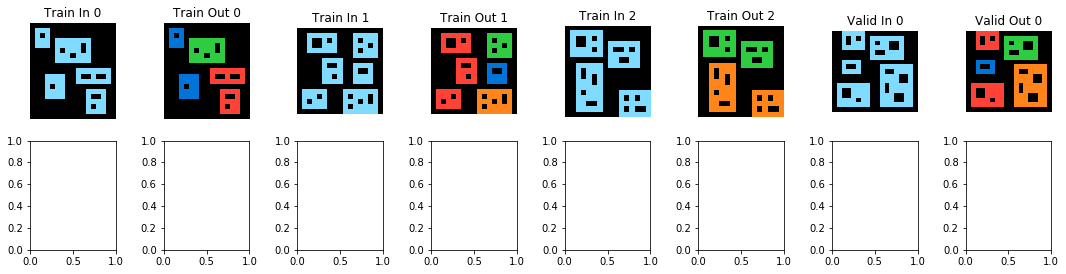

In [35]:
taskname = '37d3e8b2' #'ae58858e'
plot_task(taskname, path = evaluation_path) #training_path #evaluation_path)#, max_train=2)

plt.show() 

# submission

In [37]:
submission = pd.read_csv(data_path / 'sample_submission.csv', index_col='output_id')
display(submission.head())


,output
output_id,
00576224_0,|32|78| |32|78| |00|00|
009d5c81_0,|00000000000000|00000888888888|00000800080808|...
00dbd492_0,|00000000000222220000|02222222220200020000|020...
03560426_0,|0000000000|0000000000|0000000000|0000000000|0...
05a7bcf2_0,|000000000020000000080000000000|00000000002220...


In [29]:
path=test_path
test_tasks = set([s.split('_')[0] for s in submission.index.tolist()])

#training_tasks=['','08ed6ac7'] #['','ae58858e'] #,'ae58858e', 'e0fb7511']

for i, t in enumerate(test_tasks):
    
    if i%25 == 0:
        print(f'{i} it done')
    try:
        preds = predTask(t, path = path)
        for p in preds:
            #print(preds.get(p))
            submission.loc[p, 'output'] = preds.get(p)
    except:
        None#print(f'Error in {t}')

print('Done!')

0 it done
Predicting 0a2355a6_0 ...

Predicted 0a2355a6

Predicted 0a2355a6
25 it done
Predicting 37d3e8b2_0 ...

Predicted 37d3e8b2
50 it done
Predicting 1da012fc_0 ...

Predicted 1da012fc
75 it done
Done!


In [30]:
display(submission.head())

submission.to_csv('submission.csv')

,output
output_id,
00576224_0,|32|78| |32|78| |00|00|
009d5c81_0,|00000000000000|00000888888888|00000800080808|...
00dbd492_0,|00000000000222220000|02222222220200020000|020...
03560426_0,|0000000000|0000000000|0000000000|0000000000|0...
05a7bcf2_0,|000000000020000000080000000000|00000000002220...
